In [51]:
import yfinance as yf ## for finance
import pandas as pd ## dataframes
import datetime as dt
import statsmodels.api as sm
import warnings
import random
import numpy as np ## linear algebra
import matplotlib.pyplot as plt
from scipy import stats ## main python statistical package
from pandas.plotting import lag_plot
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from datetime import date
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from scipy.signal import butter, filtfilt
from scipy.stats import spearmanr

warnings.filterwarnings("ignore")

----
# Funzioni
----


## Test stazionarietà

In [52]:
### 1. Check whether the two processes are stationary
### Two common tests are 
### A. Augmented Dickey-Fuller (ADF) Test
### B. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
### ADF test is conducted with the following assumptions:
### Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
### Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
### If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print (dfoutput)
    if dfoutput[1] > 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n")

### The KPSS test is conducted with the following assumptions.
### Null Hypothesis (HO): Series is trend stationary or series has no unit root.
### Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
### Note: The hypothesis is reversed in the KPSS test compared to ADF Test.
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    #print (kpss_output)
    if kpss_output[1] < 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n")
        
import warnings
warnings.filterwarnings("ignore")

#### Filtro passa basso

In [53]:
def lpfilter(X,cutoff=0.1,order=7):
    # Calcolare i coefficienti del filtro
    b, a = butter(order, cutoff, btype='lowpass')
    # Applicare il filtro passa-basso alla serie temporale
    X_filt = filtfilt(b, a, X)
    t=np.arange(0,len(X),1)
    # Visualizzare serie temporale originale e serie temporale filtrata
    plt.plot(t, X, alpha = 0.5,lw=0.5)
    plt.plot(t, X_filt, color='red')
    plt.show()
    return(X_filt)


### Differenziazione delle serie

In [54]:
## 2. In case not, differentiate them
#def differentiate(X_t, dt):
## 2. In case not, differentiate them
def diff(X_t, dt):
    N = len(X_t)
    diff_X_t = []
    for i in range(N):
        if i==0:
            diff = (X_t[i+1]-X_t[i])/dt
            diff_X_t.append(diff)
        
        elif i==N-1:
            diff = (X_t[i]-X_t[i-1])/dt
            diff_X_t.append(diff)
            
        else:
            diff_fw = (X_t[i+1]-X_t[i])/dt
            diff_bw = (X_t[i]-X_t[i-1])/dt
            diff = 0.5*(diff_fw+diff_bw)
            diff_X_t.append(diff)
    return diff_X_t

### Lag Plot

In [55]:
def lag_plots(data_df):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    lag_plot(data_df[data_df.columns[0]], ax=ax1)
    ax1.set_title(data_df.columns[0]);

    lag_plot(data_df[data_df.columns[1]], ax=ax2)
    ax2.set_title(data_df.columns[1]);

    ax1.set_ylabel('$y_{t+1}$');
    ax1.set_xlabel('$y_t$');
    ax2.set_ylabel('$y_{t+1}$');
    ax2.set_xlabel('$y_t$');

    plt.tight_layout()

### Splitter

In [56]:
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

In [57]:
def select_p(train_df, maxlag=20):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,maxlag)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

### Cross-correlation analysis

In [58]:
## 3. perform cross correlation analysis
def CrossCorrelationAnalysis(X, Y, maxlag, dt=1):
    """
    Perform the lagged-cross-correlation analysis between two time series X(t) and Y(t).
    X, Y are two 1-d numpy arrays.
    dt is the time step of the time series (default 1 a.u.) - it could be specified w.r.t a given unit
    """
    
    ### Make sure the two time series are stationary
    ### Performing for example the Augmented Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    result_X, result_Y = adfuller(X), adfuller(Y)
    if (result_X[1] > 0.05 or result_Y[1]>0.05):
        print("Time Series are not stationary")
        return
    else:
        ## we consider X(t+lag), Y(t)
        ## so that for lag<0 X preceeds Y and vice-versa.
        dim = len(X)
        lags = np.arange(-maxlag, maxlag+1, 1)
        lagged_cross_corr = []
        for lag in lags:
            XY = [(X[t+lag], Y[t]) for t in range(dim-np.abs(lag))]
            X_lagged = [el[0] for el in XY]
            Y_lagged = [el[1] for el in XY]
            lagged_cross_corr.append(stats.pearsonr(X_lagged, Y_lagged)[0])
            
        plt.figure(figsize=(3, 3), dpi=180)
        lags_min = [l for l in lags if l<=0]
        lags_maj = [l for l in lags if l>=0]
        lcc_min = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]<=0]
        lcc_maj = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]>=0]
        plt.plot(lags_min, lcc_min, lw=1, color='b')
        plt.plot(lags_maj, lcc_maj, lw=1, color='r')
        plt.vlines(0, -1, 1, lw=2, ls='--', color='k')
        plt.xlabel('time lags'), plt.ylabel('lagged-cross-correlation')
        plt.text(-maxlag/2, 0.8, 'X preceeds Y', color='b')
        plt.text(maxlag/2, 0.8, 'Y preceeds X', color='r')
        plt.show()

In [59]:
# Cross-correlation di x e y. Ritardo/anticipo x quindi il ritardo segnato sulle ascisse è attribuito alle y

def cross_correlation(x, y, max_lag,ax=plt, periodo='giorni', color1='royalblue',color2='navy'):
  tau_max = 0
  tau_min = 0
  max = -1
  min = 1
  testo = 'Ritardo ['+periodo+']'
  result_x, result_y = adfuller(x), adfuller(x)
  if (result_x[1] > 0.05 or result_y[1]>0.05):
      print("Time Series are NOT stationary")
      return
  else:
    dim = len(x)
    lags = np.arange(-max_lag, max_lag+1, 1)
    lagged_cross_corr = []
    df = {"x": x, "y": y}
    df = pd.DataFrame(df)
    for lag in lags:
      df_shifted = df.copy()
      df_shifted["x"] = df_shifted["x"].shift(lag)
      df_shifted = df_shifted.dropna()
      corr, p = spearmanr(df_shifted['x'], df_shifted["y"])
      lagged_cross_corr.append(corr)
      if corr > max:
        tau_max = lag
        max  = corr 
      if corr < min:
        tau_min = lag
        min  = corr

    ax.plot(lags, lagged_cross_corr, "^", markersize=5, color=color2, alpha=0.7)
    ax.plot(lags, lagged_cross_corr, color=color1, alpha=0.7)
    if ax==plt:
      plt.xlabel(testo), plt.ylabel('Cross-correlation')
    else:
      ax.set_xlabel(testo), ax.set_ylabel('Cross-correlation')
    ax.axvline(x=0, color='black', linewidth = 1)
    ax.axhline(y=0, color='black', linewidth = 1)
  

    print("Correlazione massima: ", max, " con ritardo di", tau_max, periodo)
    print("Correlazione minima: ", min, " con ritardo di", tau_min, periodo)

    return tau_max, tau_min

## Granger Matrix

In [60]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [61]:
def normalize(X):
    #trovo il massimo della serie delle specie
    max = np.amax(np.abs(X))
    #definisco il coeficiente di normalizzazione
    a = 1/max
    #normalizzo la serie
    X1 = a * X
    return X1

----
# Le principali banche USA hanno una relazione causale reciproca significativa
----

#### Titoli Borsa

In [62]:
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime(2015, 2, 1)
jpm = yf.Ticker('JPM').history(interval='1mo', start=start_date, end=end_date)
gs = yf.Ticker('GS').history(interval='1mo', start=start_date, end=end_date)
wf = yf.Ticker('WFC').history(interval='1mo', start=start_date, end=end_date)
boa = yf.Ticker('BAC').history(interval='1mo', start=start_date, end=end_date)
cg = yf.Ticker('C').history(interval='1mo', start=start_date, end=end_date)

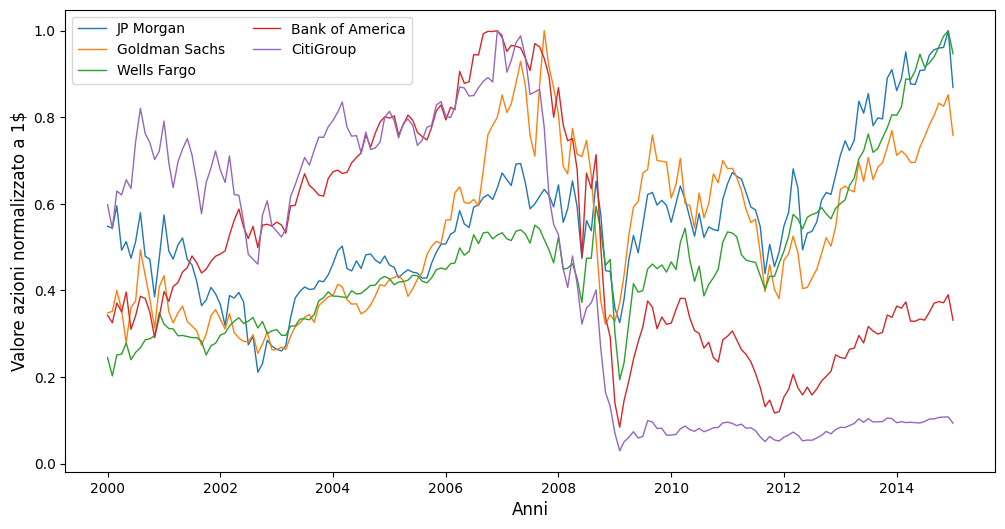

In [63]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(normalize(jpm['Close']),lw=1, label='JP Morgan')
plt.plot(normalize(gs['Close']),lw=1, label='Goldman Sachs')
plt.plot(normalize(wf['Close']),lw=1, label='Wells Fargo')
plt.plot(normalize(boa['Close']),lw=1, label='Bank of America')
plt.plot(normalize(cg['Close']),lw=1, label='CitiGroup')
#plt.axvline(x=dt.datetime(2008, 9, 15), linestyle='--', color='k', lw=1, label='crisi', alpha=0.5)
plt.xlabel('Anni',fontsize=12)
plt.ylabel('Valore azioni normalizzato a 1$',fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2)
fig.savefig('azioni1.pdf')

In [64]:

jpm_v = jpm['Close']
gs_v = gs['Close']
wf_v = wf['Close']
boa_v = boa['Close']
cg_v = cg['Close']
t = np.arange(0, len(jpm) , 1)

dati = {'JPM':jpm_v,'GS':gs_v,'WF':wf_v,'BoA':boa_v,'CG':cg_v}
stock = pd.DataFrame(dati)
stock.to_excel('stock.xlsx', index=False)
date_vector = stock[1:].index.tolist()

In [65]:
jpm_unf_pch = np.diff(jpm_v) / jpm_v[:-1] * 100
gs_unf_pch = np.diff(gs_v) / gs_v[:-1] * 100
wf_unf_pch = np.diff(wf_v) / wf_v[:-1] * 100
boa_unf_pch = np.diff(boa_v) / boa_v[:-1] * 100
cg_unf_pch = np.diff(cg_v) / cg_v[:-1] * 100
stock_unf_pch = pd.DataFrame({'JPM': jpm_unf_pch, 'GS':gs_unf_pch, 'WF': wf_unf_pch, 'BoA':boa_unf_pch, 'CG':cg_unf_pch})
stock_unf_pch

,JPM,GS,WF,BoA,CG
Date,,,,,
2000-01-01 00:00:00-05:00,-0.758523,1.093546,-17.343694,-5.032258,-9.210523
2000-02-01 00:00:00-05:00,9.497669,13.783758,23.925621,13.994544,16.021862
2000-03-01 00:00:00-05:00,-17.276014,-11.401346,0.766853,-5.528502,-1.461326
2000-04-01 00:00:00-05:00,4.092988,-21.011530,10.197809,13.137793,5.673071
2000-05-01 00:00:00-04:00,-7.489479,28.844511,-13.906821,-21.722786,-3.115611
...,...,...,...,...,...
2014-08-01 00:00:00-04:00,1.328856,2.807897,1.541081,5.966414,0.329136
2014-09-01 00:00:00-04:00,0.398417,3.497296,2.351996,0.955445,3.299855
2014-10-01 00:00:00-04:00,0.141051,-0.831575,2.618219,-0.699305,0.841135


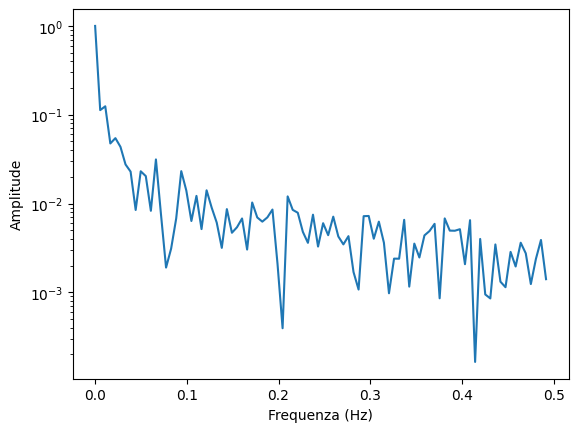

In [66]:
# calcolare la trasformata di Fourier
fft_x = np.fft.fft(jpm['Close'])

# visualizzare lo spettro delle frequenze
freqs = np.fft.fftfreq(len(jpm['Close']))
plt.plot(freqs[0:(len(freqs)//2)], normalize(np.abs(fft_x[0:(len(freqs)//2)])))
plt.semilogy()
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Amplitude')
plt.show()

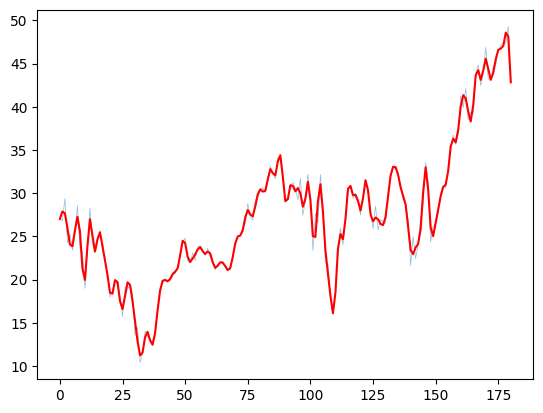

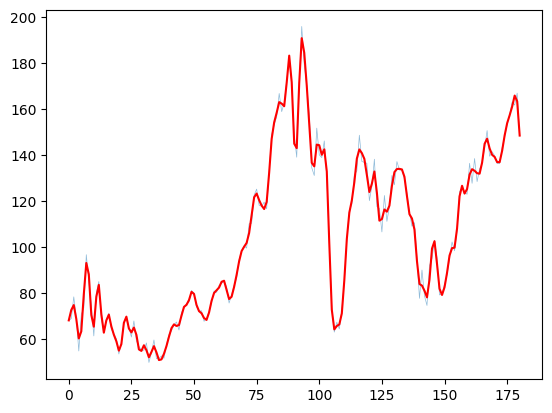

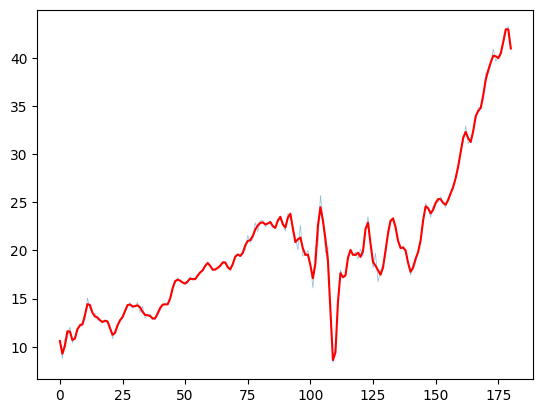

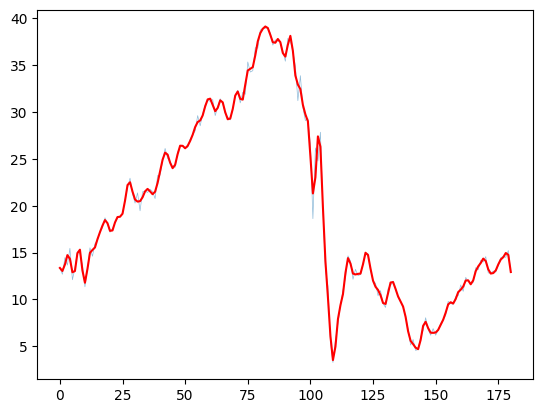

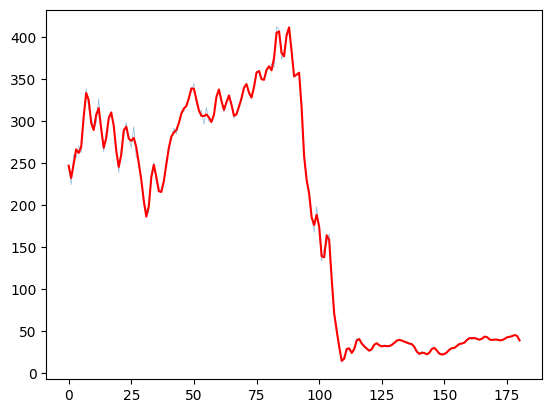

In [67]:
c =0.6
o = 5
jpm_f = lpfilter(stock['JPM'], cutoff = c, order = o)
gs_f = lpfilter(stock['GS'], cutoff = c, order = o)
wf_f = lpfilter(stock['WF'], cutoff = c, order = o)
boa_f = lpfilter(stock['BoA'], cutoff = c, order = o)
cg_f = lpfilter(stock['CG'], cutoff = c, order = o)
dff = pd.DataFrame({'JPM':jpm_f,'GS':gs_f,'WF':wf_f,'BOA':boa_f,'CG':cg_f})
dff.to_excel('stockfiltered.xlsx',index=False)

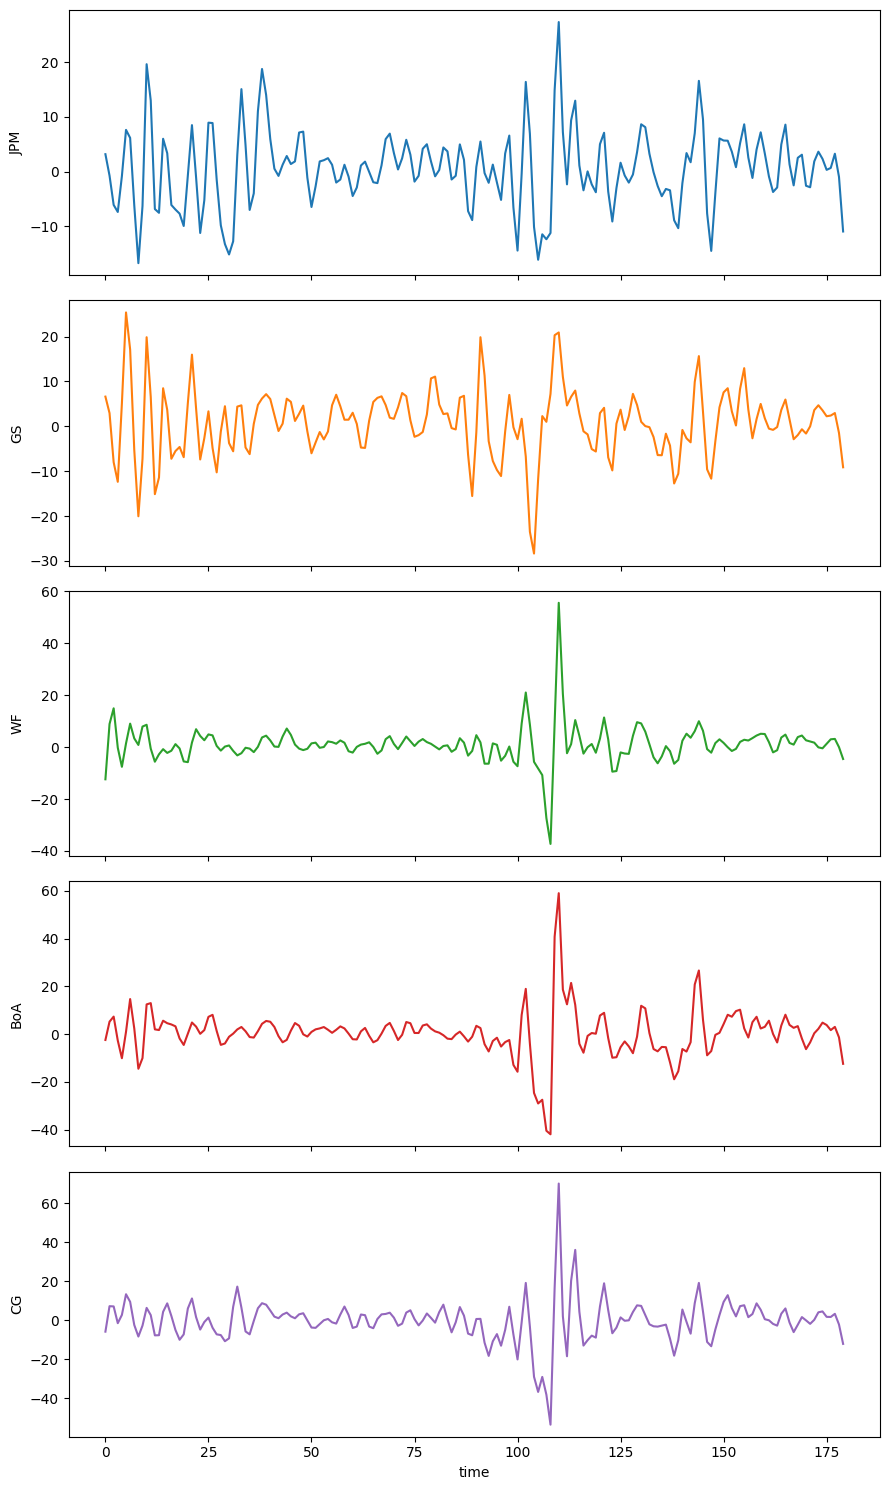

In [68]:
# Calcolare la variazione percentuale rispetto al valore precedente
jpm_pch = np.diff(jpm_f) / jpm_f[:-1] * 100
gs_pch = np.diff(gs_f) / gs_f[:-1] * 100
wf_pch = np.diff(wf_f) / wf_f[:-1] * 100
boa_pch = np.diff(boa_f) / boa_f[:-1] * 100
cg_pch = np.diff(cg_f) / cg_f[:-1] * 100
stock_pch = pd.DataFrame({'JPM': jpm_pch, 'GS':gs_pch, 'WF': wf_pch, 'BoA':boa_pch, 'CG':cg_pch})
fig,ax = plt.subplots(5, figsize=(9,15), sharex=True)
plot_cols = ['JPM', 'GS', 'WF', 'BoA', 'CG']
stock_pch[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('time')
plt.tight_layout()
plt.show()

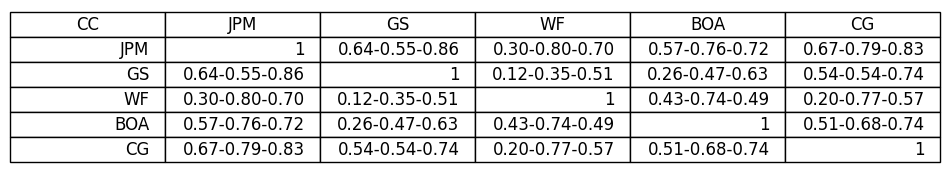

In [69]:
# leggi i dati dalla tabella su Excel
df = pd.read_excel('CROSSCORR.xlsx', sheet_name='Foglio1')

# creazione del subplot
fig, ax = plt.subplots(figsize=(12,2))

# crea la tabella
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# nascondi gli assi del subplot
ax.axis('off')

# mostra il subplot
plt.show()
fig.savefig('cc1.pdf')


Correlazione massima:  0.6464716006884682  con ritardo di 0 mesi
Correlazione minima:  -0.3887310760657808  con ritardo di 2 mesi
Correlazione massima:  0.8389057750759878  con ritardo di 0 mesi
Correlazione minima:  -0.27747747747747753  con ritardo di -12 mesi


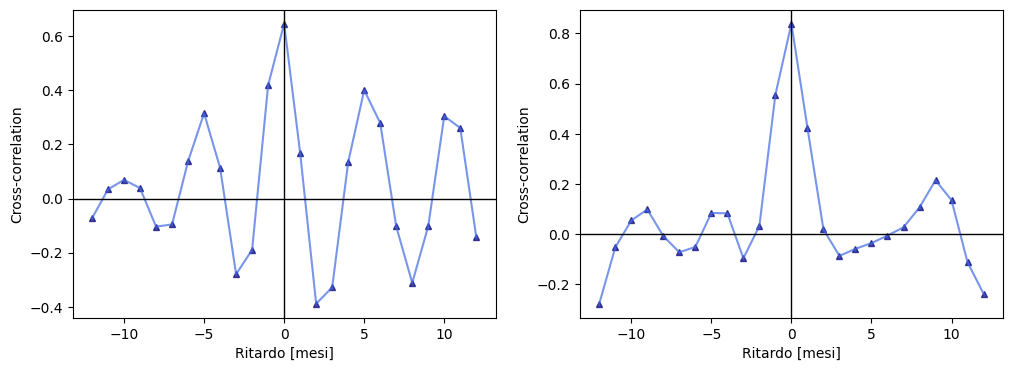

In [70]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
cross_correlation(jpm_pch[0:7*12],cg_pch[0:7*12], max_lag=12, periodo='mesi',ax=axes[0])
cross_correlation(jpm_pch[11*12:],cg_pch[11*12:], max_lag=12, periodo='mesi',ax=axes[1])
fig.savefig('ccf1.pdf')


#### CROSS CORRELATION + GRANGER JPM-ALTRE BANCHE


In [71]:
adf_test(jpm_pch)
kpss_test(jpm_pch)
adf_test(gs_pch)
kpss_test(gs_pch)
adf_test(wf_pch)
kpss_test(wf_pch)
adf_test(boa_pch)
kpss_test(boa_pch)
adf_test(cg_pch)
kpss_test(cg_pch)

Results of Dickey-Fuller Test:

*** Time series is stationary ***

Results of KPSS Test:

*** Time series is stationary ***

Results of Dickey-Fuller Test:

*** Time series is stationary ***

Results of KPSS Test:

*** Time series is stationary ***

Results of Dickey-Fuller Test:

*** Time series is stationary ***

Results of KPSS Test:

*** Time series is stationary ***

Results of Dickey-Fuller Test:

*** Time series is stationary ***

Results of KPSS Test:

*** Time series is stationary ***

Results of Dickey-Fuller Test:

*** Time series is stationary ***

Results of KPSS Test:

*** Time series is stationary ***



Pre crisi

Correlazione massima:  0.6364818701897353  con ritardo di 0 mesi
Correlazione minima:  -0.28475573245042446  con ritardo di 2 mesi
Correlazione massima:  0.30190558505165244  con ritardo di 0 mesi
Correlazione minima:  -0.3775640376632581  con ritardo di -6 mesi
Correlazione massima:  0.5704325636909906  con ritardo di 0 mesi
Correlazione minima:  -0.38639005318586883  con ritardo di -2 mesi
Correlazione massima:  0.6716302424167593  con ritardo di 0 mesi
Correlazione minima:  -0.41210242682540243  con ritardo di 2 mesi


(0, 2)

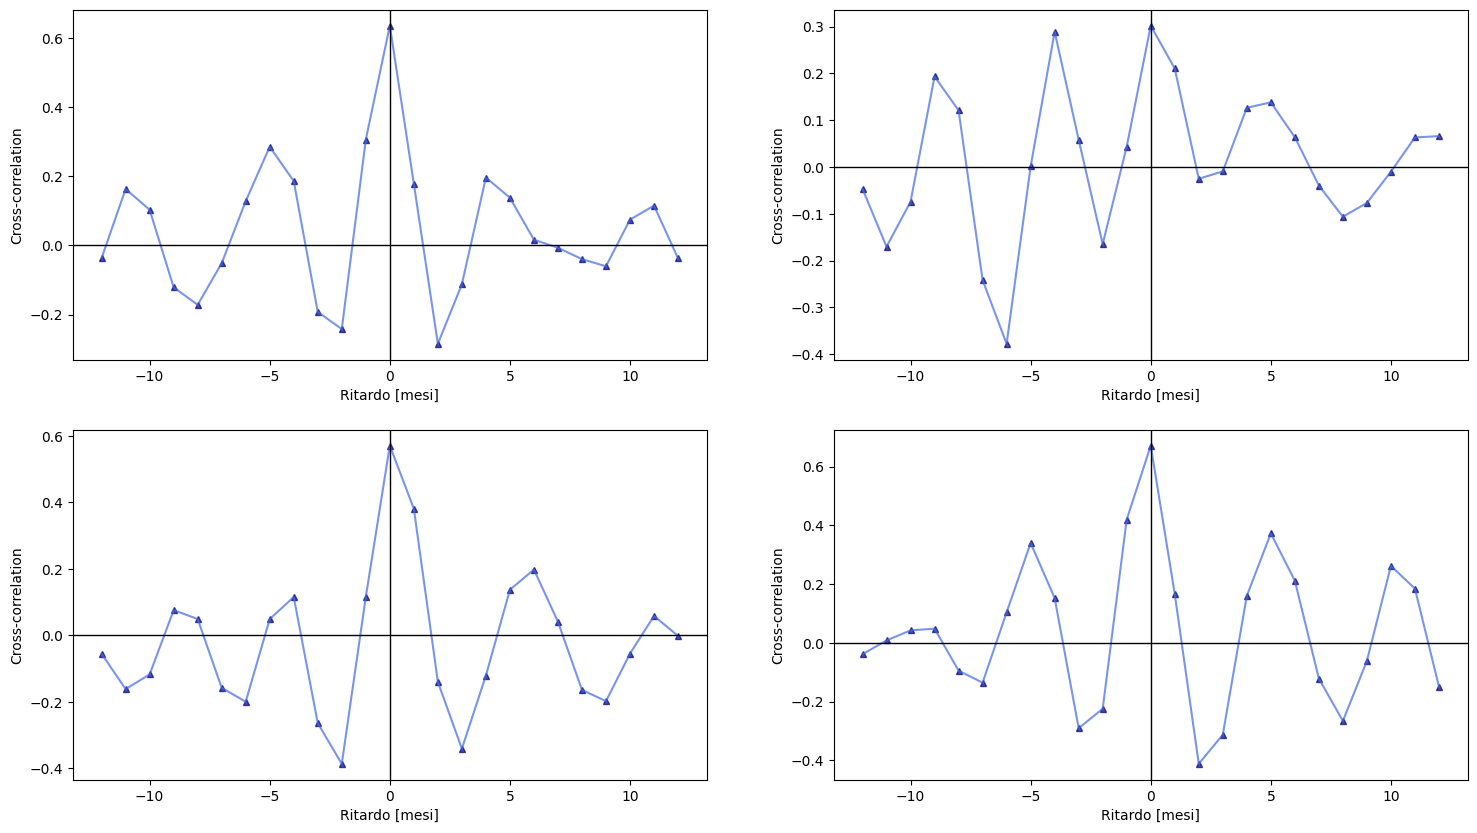

In [72]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds = int(12*7.5)
# Disegna i grafici
cross_correlation(jpm_pch[0:ds],gs_pch[0:ds], max_lag=12,ax=axes[0, 0],periodo='mesi')
cross_correlation(jpm_pch[0:ds],wf_pch[0:ds], max_lag=12, periodo='mesi',ax=axes[0, 1])
cross_correlation(jpm_pch[0:ds],boa_pch[0:ds], max_lag=12, periodo='mesi',ax=axes[1, 0])
cross_correlation(jpm_pch[0:ds],cg_pch[0:ds], max_lag=12, periodo='mesi',ax=axes[1, 1])


Correlazione massima:  0.20148575127537258  con ritardo di -4 mesi
Correlazione minima:  -0.2301601020702144  con ritardo di -6 mesi
Correlazione massima:  0.26639137737961927  con ritardo di 1 mesi
Correlazione minima:  -0.2748907271610736  con ritardo di -2 mesi
Correlazione massima:  0.5354042322300596  con ritardo di 0 mesi
Correlazione minima:  -0.254693388749956  con ritardo di 8 mesi


(0, 8)

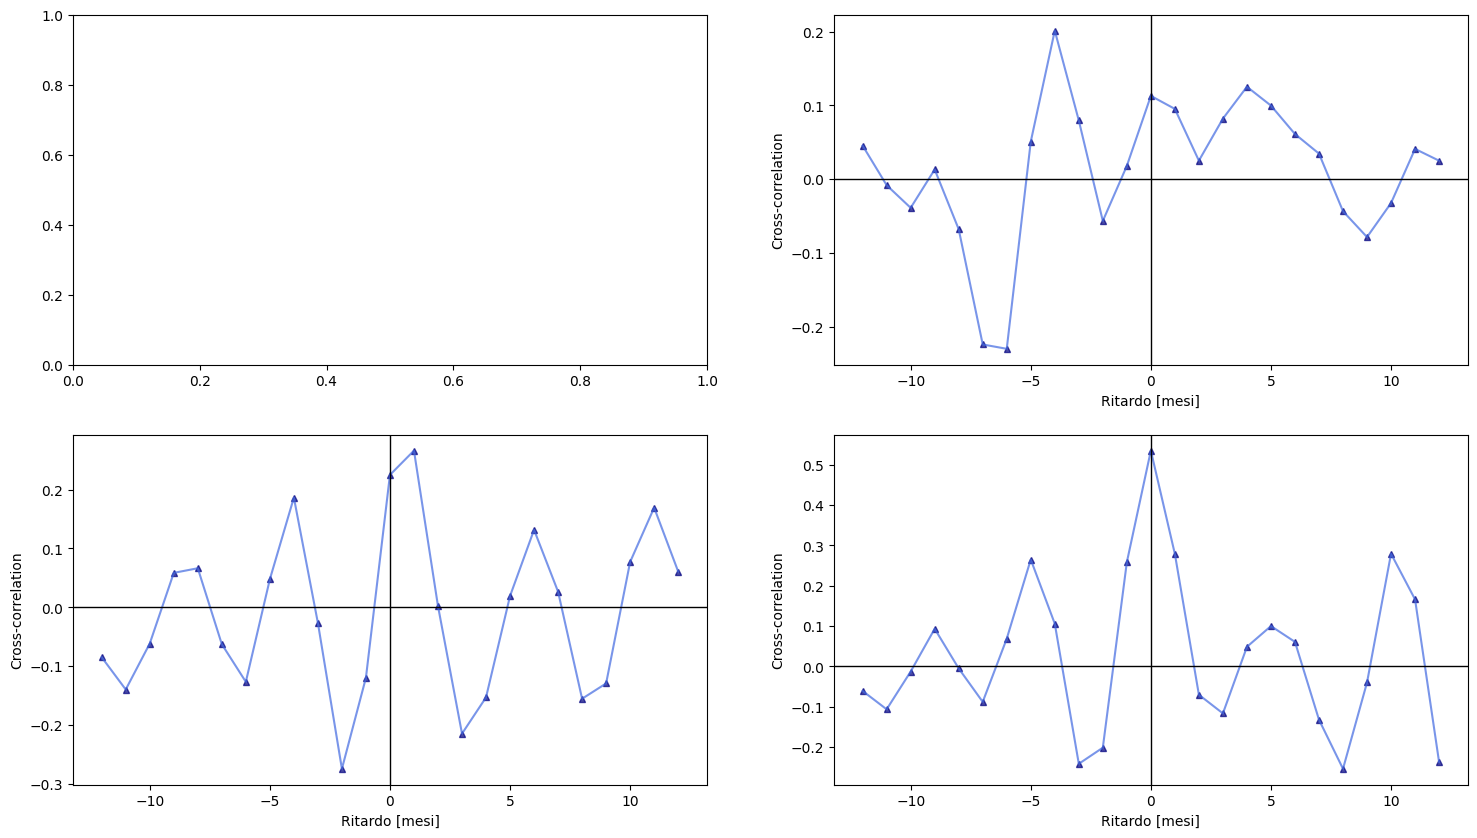

In [73]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds = int(12*8)
# Disegna i grafici
cross_correlation(gs_pch[0:ds],wf_pch[0:ds], max_lag=12, periodo='mesi',ax=axes[0, 1])
cross_correlation(gs_pch[0:ds],boa_pch[0:ds], max_lag=12, periodo='mesi',ax=axes[1, 0])
cross_correlation(gs_pch[0:ds],cg_pch[0:ds], max_lag=12, periodo='mesi',ax=axes[1, 1])

Correlazione massima:  0.42936114204718034  con ritardo di 0 mesi
Correlazione minima:  -0.3197723141890053  con ritardo di -2 mesi
Correlazione massima:  0.21974228303342228  con ritardo di -6 mesi
Correlazione minima:  -0.24232431079330874  con ritardo di 2 mesi


(-6, 2)

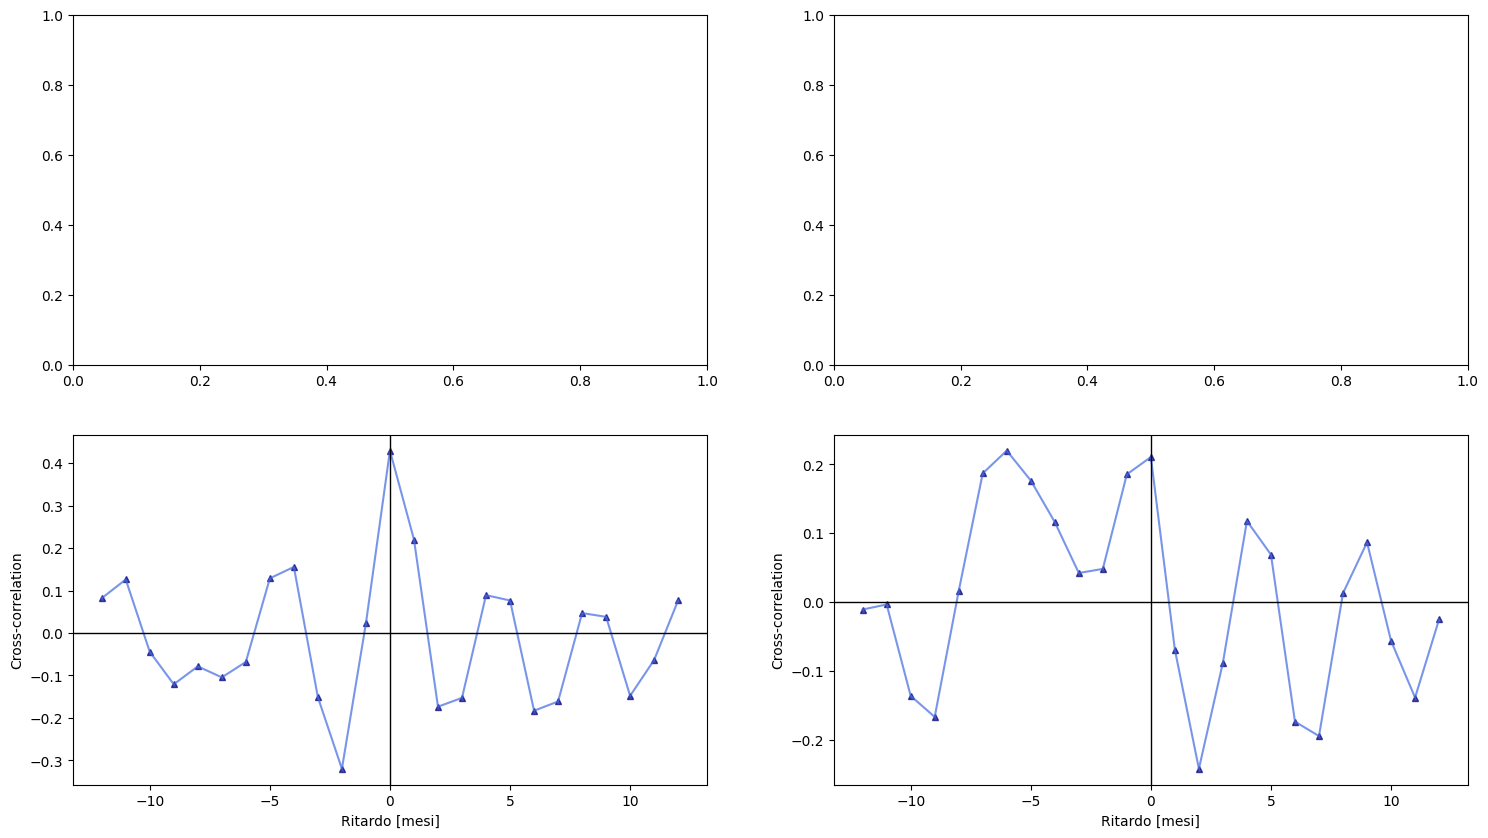

In [74]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds = int(12*7)
# Disegna i grafici
cross_correlation(wf_pch[0:ds],boa_pch[0:ds], max_lag=12, periodo='mesi',ax=axes[1, 0])
cross_correlation(wf_pch[0:ds],cg_pch[0:ds], max_lag=12, periodo='mesi',ax=axes[1, 1])

Correlazione massima:  0.512139313556748  con ritardo di 0 mesi
Correlazione minima:  -0.5086035197701375  con ritardo di 2 mesi


(0, 2)

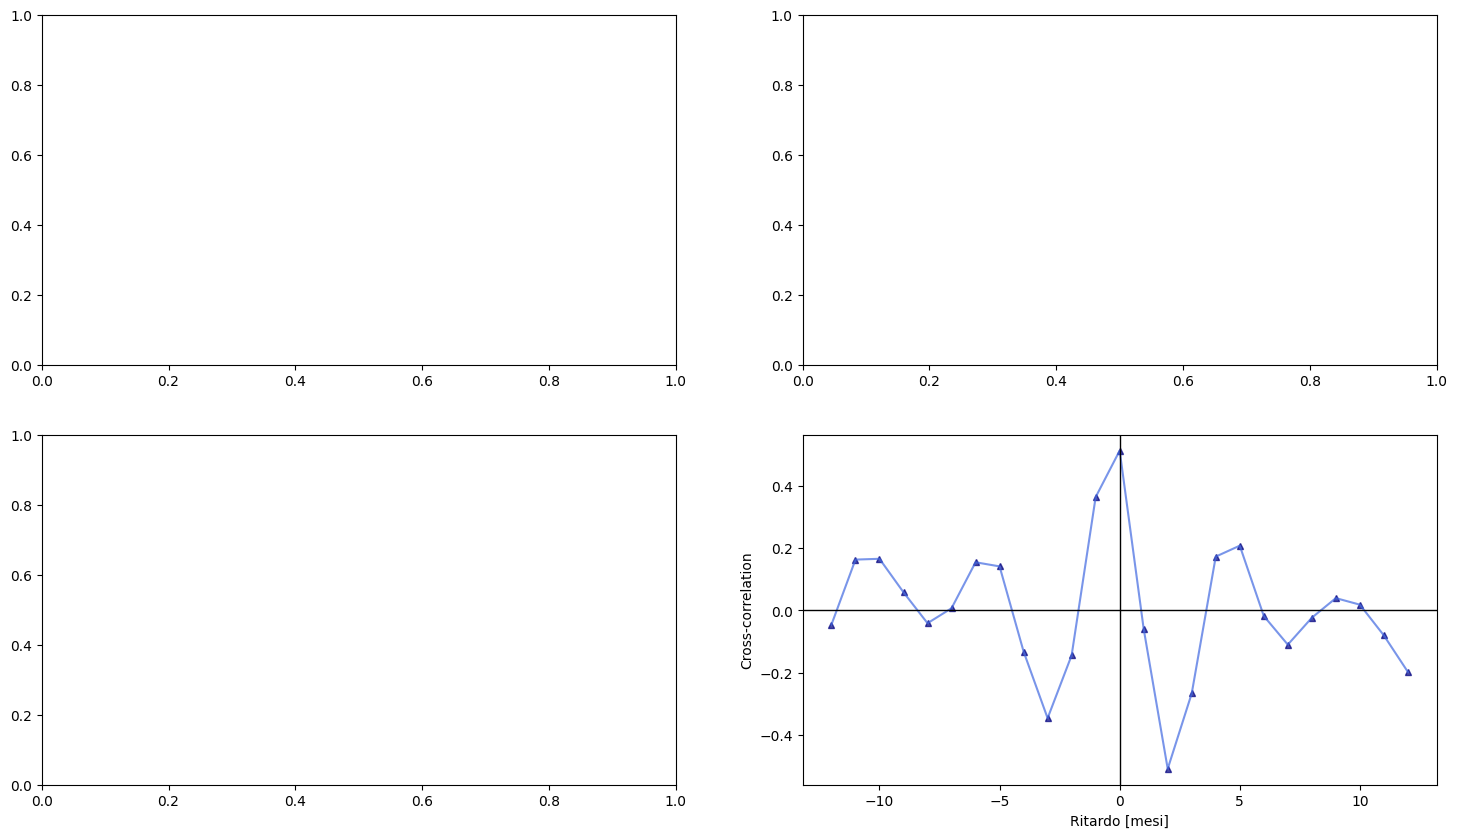

In [75]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds = int(12*7)
# Disegna i grafici
cross_correlation(boa_pch[0:ds],cg_pch[0:ds], max_lag=12, periodo='mesi',ax=axes[1, 1])

Durante la crisi

Correlazione massima:  0.551643192488263  con ritardo di 0 mesi
Correlazione minima:  -0.15335491208118274  con ritardo di 2 mesi
Correlazione massima:  0.8023667116856391  con ritardo di 0 mesi
Correlazione minima:  -0.2998225654942073  con ritardo di 6 mesi
Correlazione massima:  0.7619782622676701  con ritardo di 0 mesi
Correlazione minima:  -0.2575305291723203  con ritardo di -6 mesi
Correlazione massima:  0.7972538426908484  con ritardo di 0 mesi
Correlazione minima:  -0.25160212921406955  con ritardo di 6 mesi


(0, 6)

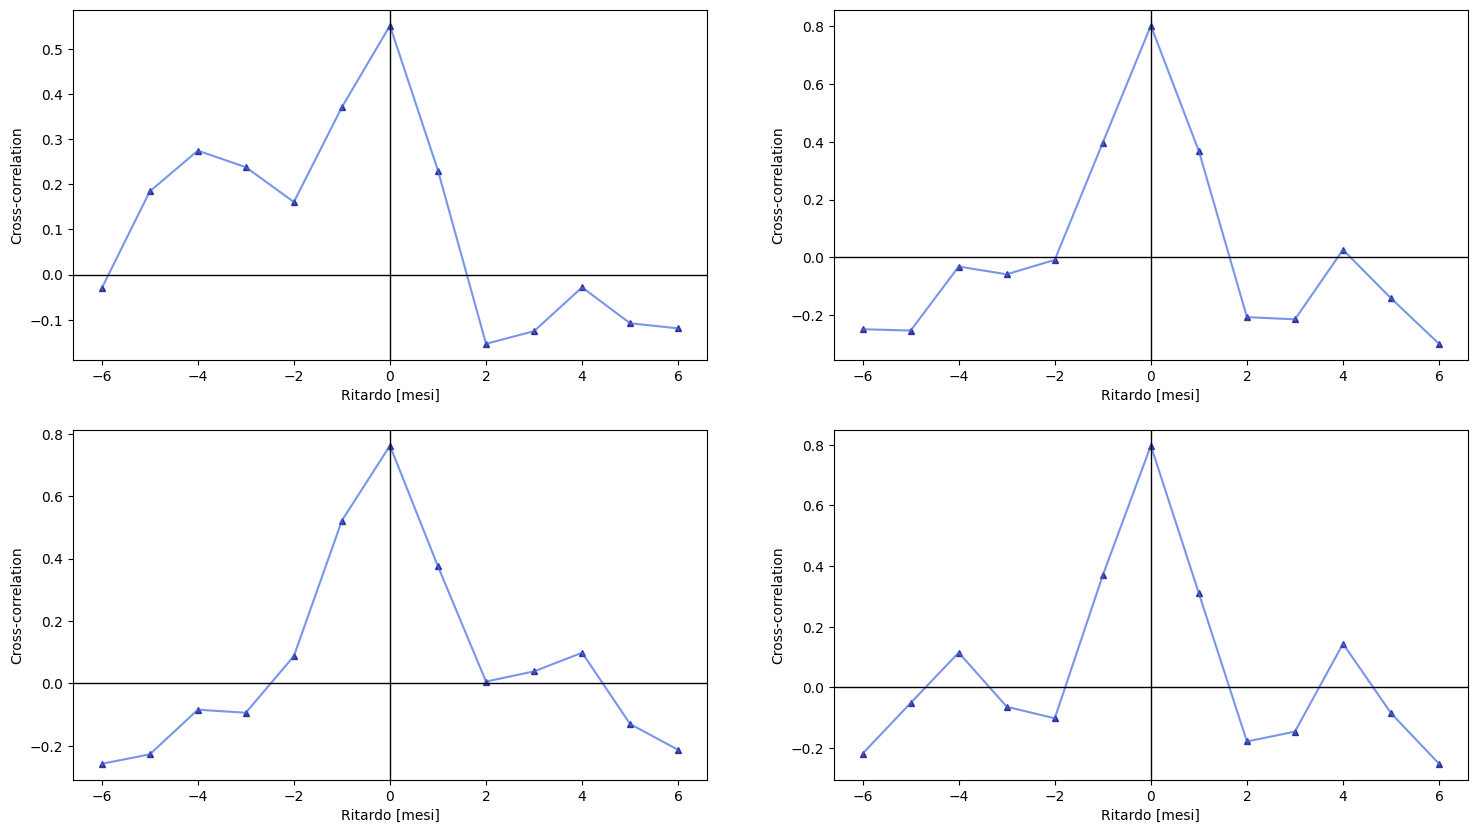

In [76]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds= int(6*12)
ds1 = int(12*12)
# Disegna i grafici
cross_correlation(jpm_pch[ds:ds1],gs_pch[ds:ds1], max_lag=6,ax=axes[0, 0],periodo='mesi')
cross_correlation(jpm_pch[ds:ds1],wf_pch[ds:ds1], max_lag=6, periodo='mesi',ax=axes[0, 1])
cross_correlation(jpm_pch[ds:ds1],boa_pch[ds:ds1], max_lag=6, periodo='mesi',ax=axes[1, 0])
cross_correlation(jpm_pch[ds:ds1],cg_pch[ds:ds1], max_lag=6, periodo='mesi',ax=axes[1, 1])

Correlazione massima:  0.3577722040002573  con ritardo di 0 mesi
Correlazione minima:  -0.19219288174512056  con ritardo di 6 mesi
Correlazione massima:  0.47466074988745266  con ritardo di 0 mesi
Correlazione minima:  -0.09019075744273287  con ritardo di -5 mesi
Correlazione massima:  0.5433789954337901  con ritardo di 0 mesi
Correlazione minima:  -0.08630915930364796  con ritardo di -2 mesi


(0, -2)

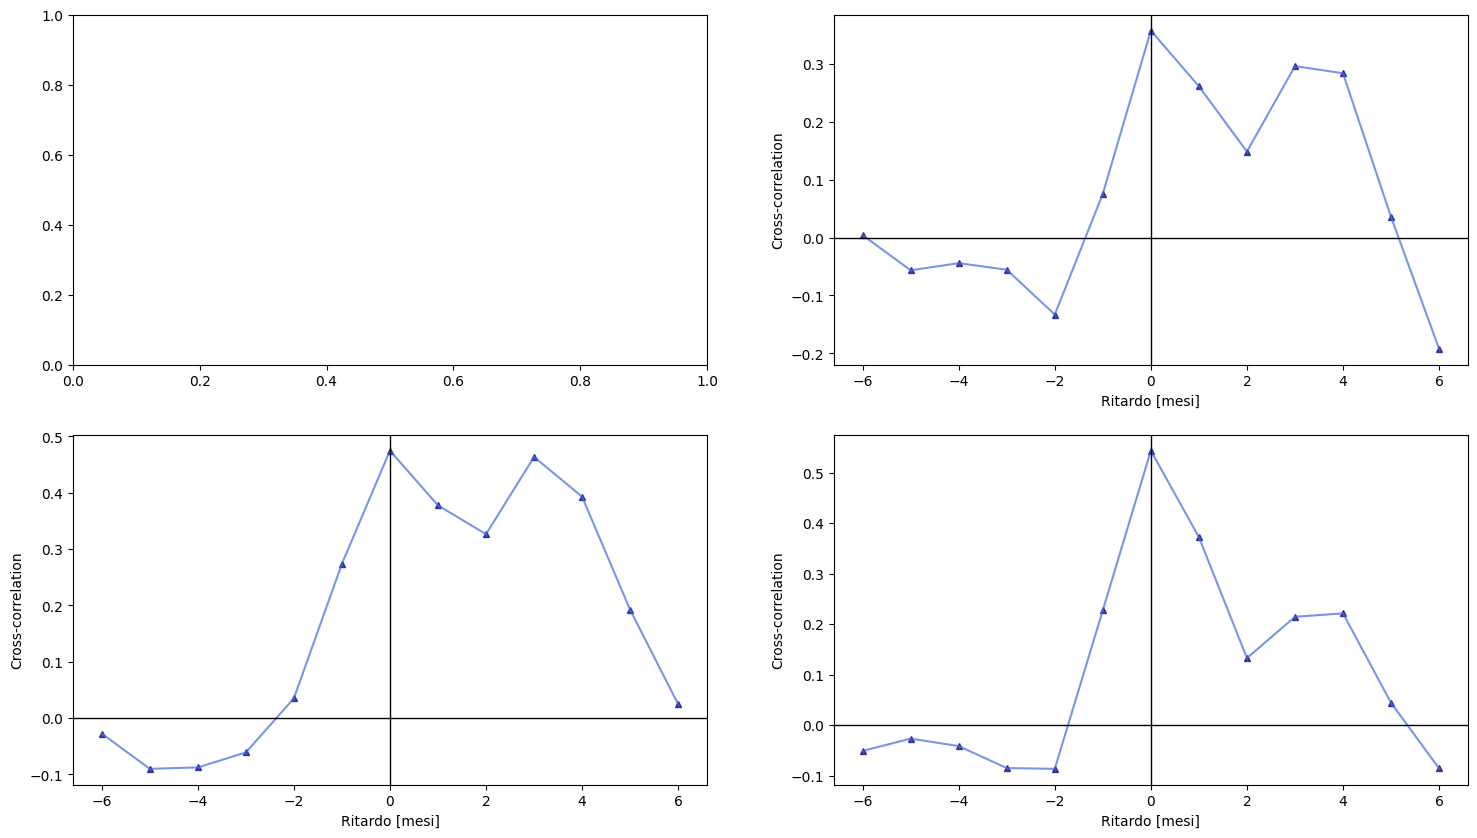

In [77]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds= int(6*12)
ds1 = int(12*12)
# Disegna i grafici
cross_correlation(gs_pch[ds:ds1],wf_pch[ds:ds1], max_lag=6, periodo='mesi',ax=axes[0, 1])
cross_correlation(gs_pch[ds:ds1],boa_pch[ds:ds1], max_lag=6, periodo='mesi',ax=axes[1, 0])
cross_correlation(gs_pch[ds:ds1],cg_pch[ds:ds1], max_lag=6, periodo='mesi',ax=axes[1, 1])

Correlazione massima:  0.7413016914271015  con ritardo di 0 mesi
Correlazione minima:  -0.3060014612253419  con ritardo di -6 mesi
Correlazione massima:  0.7714965592642615  con ritardo di 0 mesi
Correlazione minima:  -0.24199979125352267  con ritardo di -6 mesi


(0, -6)

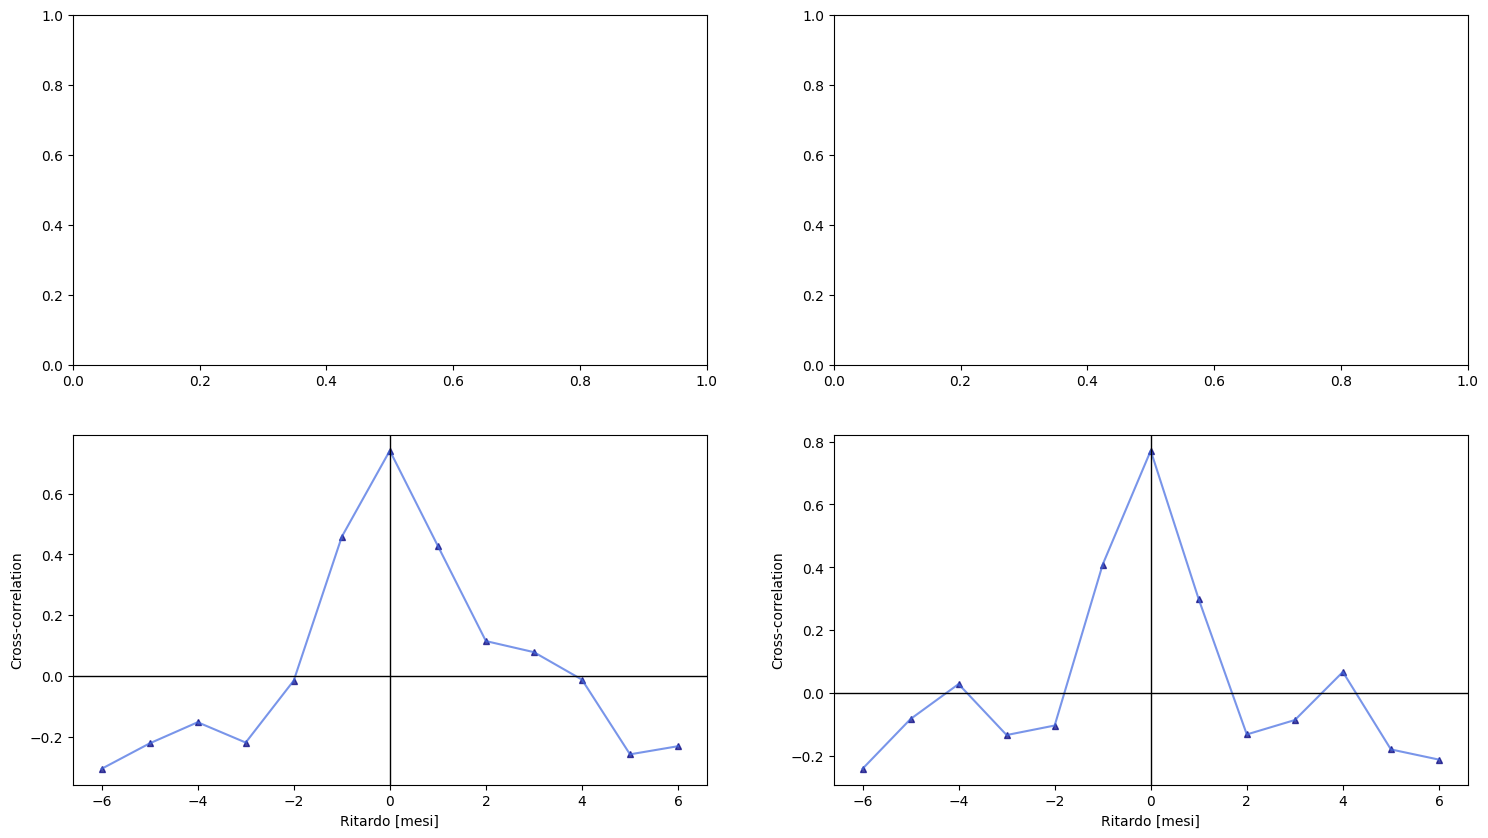

In [78]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds= int(6*12)
ds1 = int(12*12)
# Disegna i grafici
cross_correlation(wf_pch[ds:ds1],boa_pch[ds:ds1], max_lag=6, periodo='mesi',ax=axes[1, 0])
cross_correlation(wf_pch[ds:ds1],cg_pch[ds:ds1], max_lag=6, periodo='mesi',ax=axes[1, 1])

Correlazione massima:  0.6856711042510774  con ritardo di 0 mesi
Correlazione minima:  -0.2681348502244025  con ritardo di 6 mesi


(0, 6)

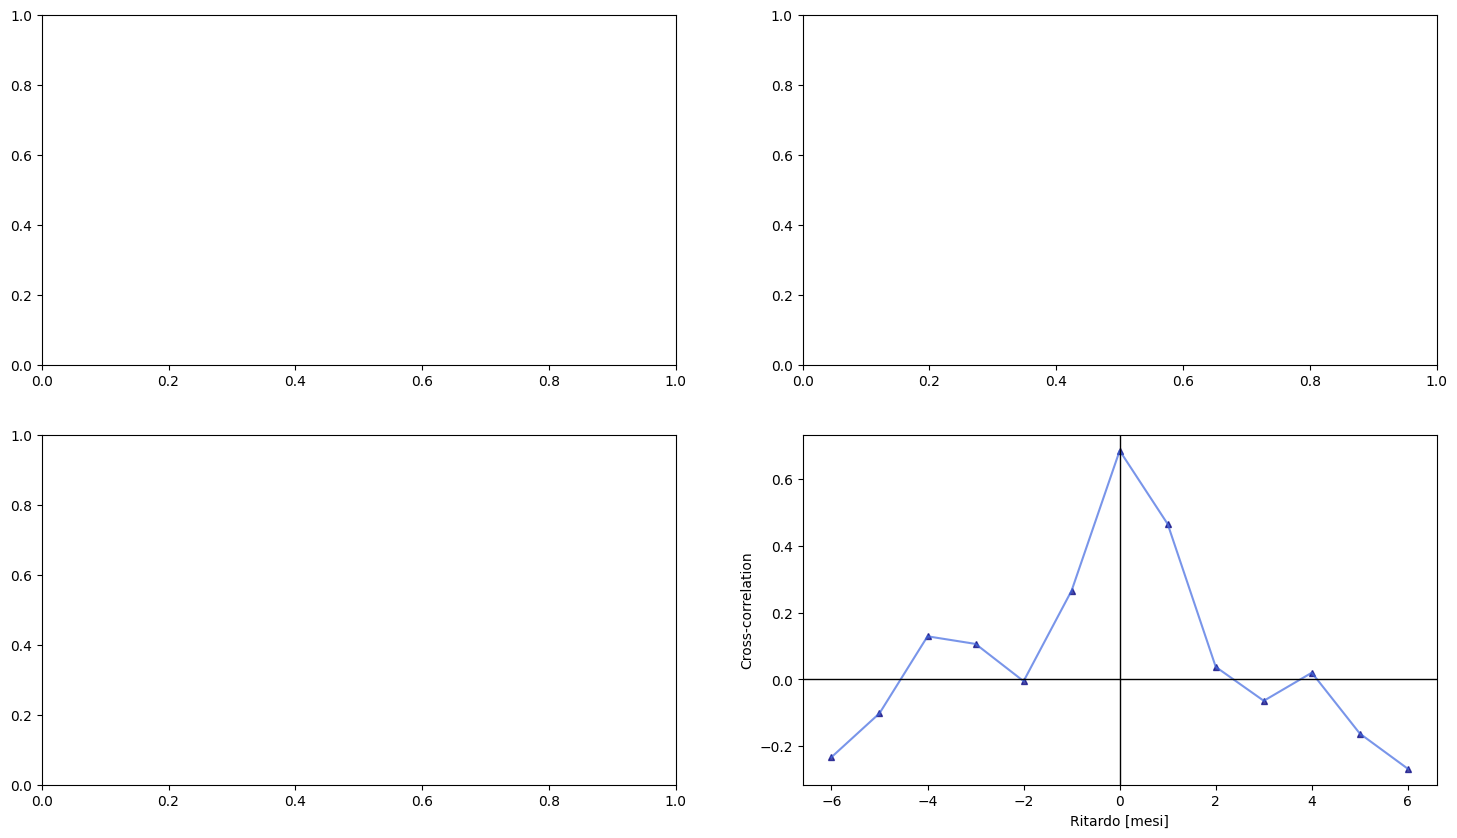

In [79]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds= int(6*12)
ds1 = int(12*12)
# Disegna i grafici
cross_correlation(boa_pch[ds:ds1],cg_pch[ds:ds1], max_lag=6, periodo='mesi',ax=axes[1, 1])

Post-crisi

Correlazione massima:  0.8610508033000434  con ritardo di 0 mesi
Correlazione minima:  -0.24298584298584303  con ritardo di -12 mesi
Correlazione massima:  0.7065783760312636  con ritardo di 0 mesi
Correlazione minima:  -0.2630662020905924  con ritardo di 7 mesi
Correlazione massima:  0.7212331741207122  con ritardo di 0 mesi
Correlazione minima:  -0.1889328063241107  con ritardo di -3 mesi
Correlazione massima:  0.8389057750759878  con ritardo di 0 mesi
Correlazione minima:  -0.27747747747747753  con ritardo di -12 mesi


(0, -12)

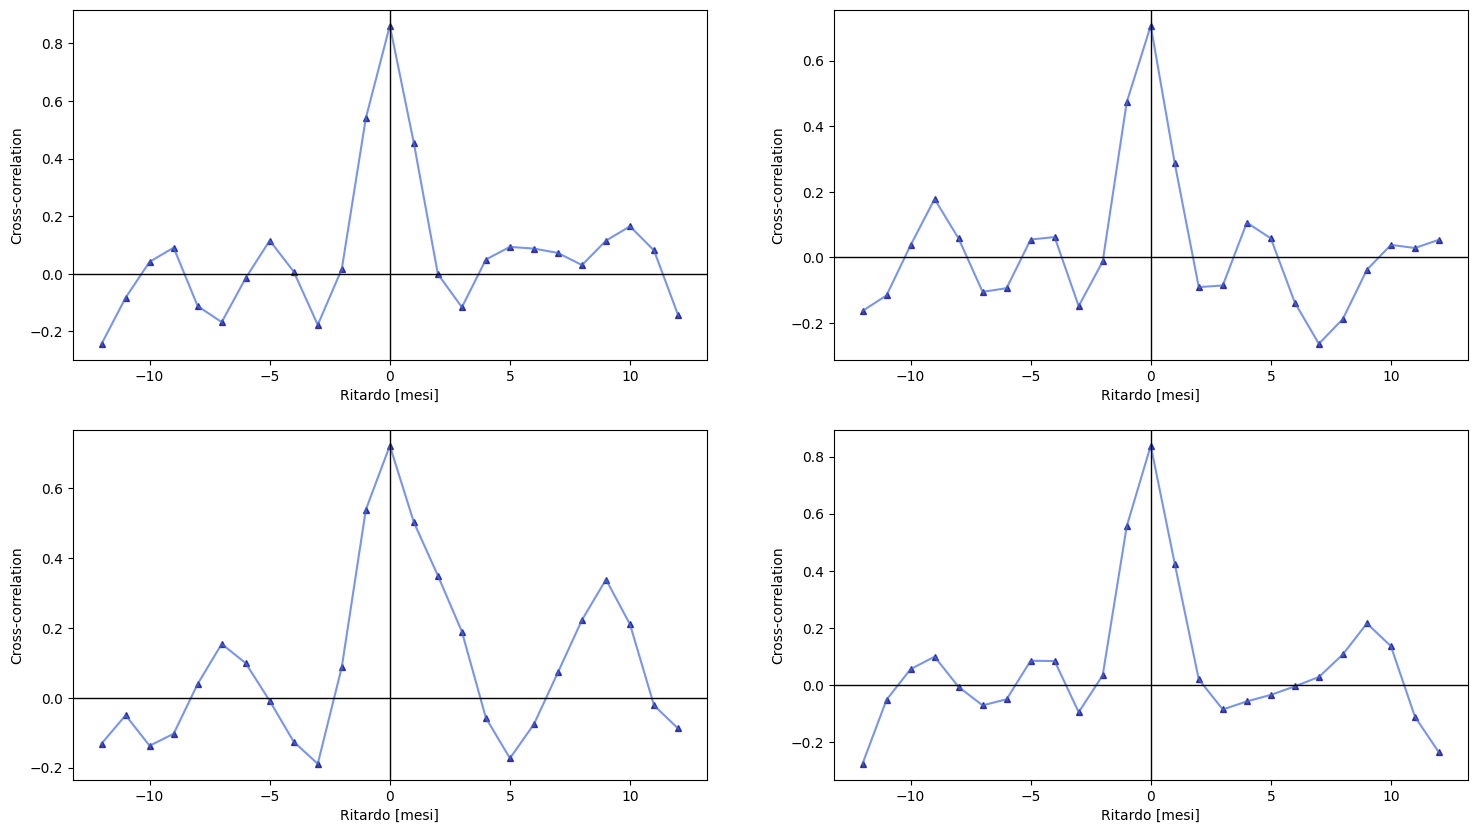

In [80]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds1 = int(11*12)
# Disegna i grafici
cross_correlation(jpm_pch[ds1:],gs_pch[ds1:], max_lag=12,ax=axes[0, 0],periodo='mesi')
cross_correlation(jpm_pch[ds1:],wf_pch[ds1:], max_lag=12, periodo='mesi',ax=axes[0, 1])
cross_correlation(jpm_pch[ds1:],boa_pch[ds1:], max_lag=12, periodo='mesi',ax=axes[1, 0])
cross_correlation(jpm_pch[ds1:],cg_pch[ds1:], max_lag=12, periodo='mesi',ax=axes[1, 1])

Correlazione massima:  0.5070100971123546  con ritardo di 0 mesi
Correlazione minima:  -0.15416666666666665  con ritardo di 8 mesi
Correlazione massima:  0.63637532960319  con ritardo di 0 mesi
Correlazione minima:  -0.15982217282578498  con ritardo di 12 mesi
Correlazione massima:  0.7414946298797352  con ritardo di 0 mesi
Correlazione minima:  -0.1961100305640456  con ritardo di -12 mesi


(0, -12)

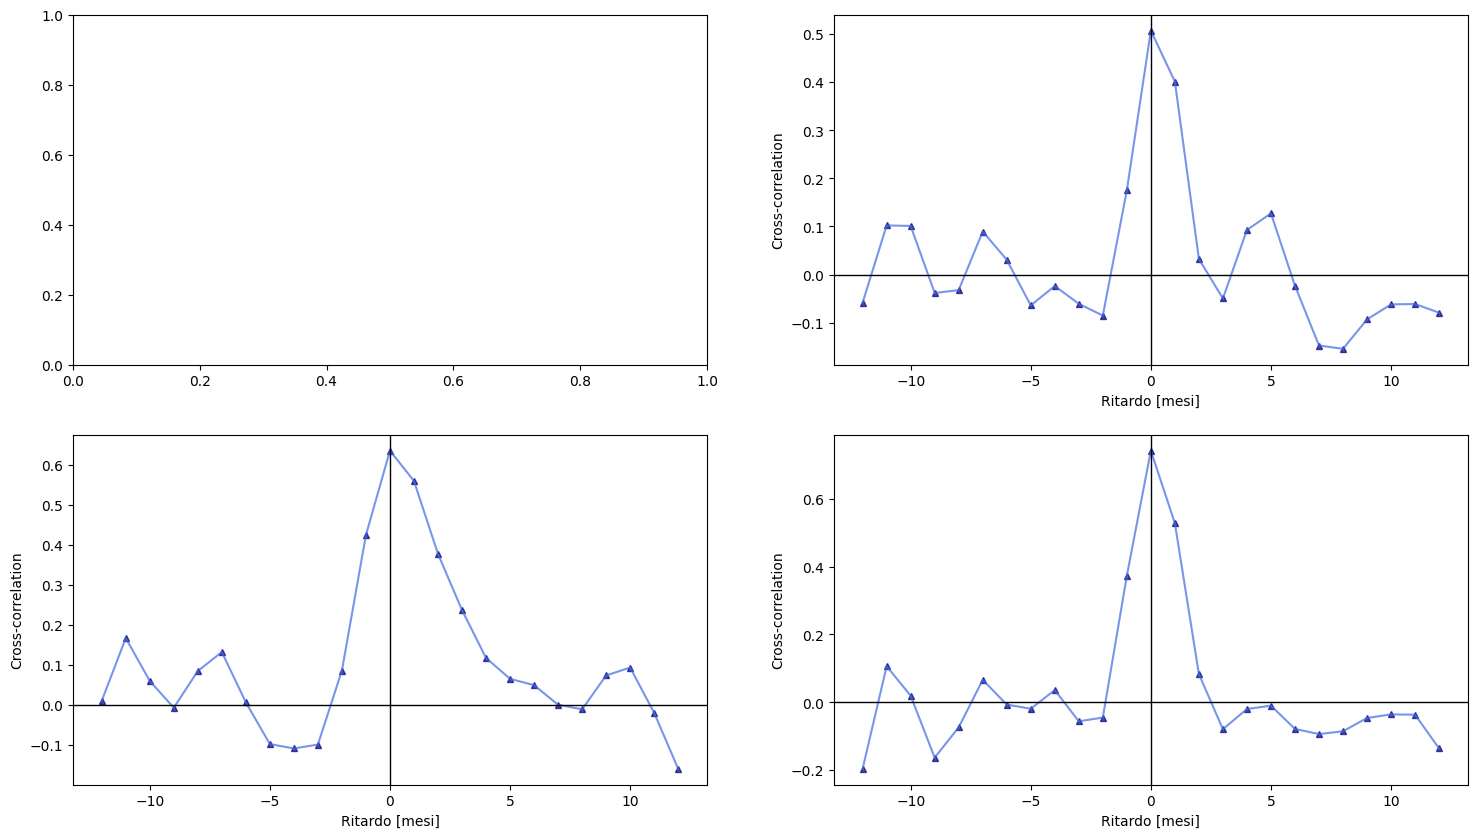

In [81]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds1 = int(9*12)
# Disegna i grafici
cross_correlation(gs_pch[ds1:],wf_pch[ds1:], max_lag=12, periodo='mesi',ax=axes[0, 1])
cross_correlation(gs_pch[ds1:],boa_pch[ds1:], max_lag=12, periodo='mesi',ax=axes[1, 0])
cross_correlation(gs_pch[ds1:],cg_pch[ds1:], max_lag=12, periodo='mesi',ax=axes[1, 1])

Correlazione massima:  0.49207555362570554  con ritardo di 0 mesi
Correlazione minima:  -0.1631578947368421  con ritardo di -9 mesi
Correlazione massima:  0.5729483282674772  con ritardo di 0 mesi
Correlazione minima:  -0.1307692307692308  con ritardo di -8 mesi


(0, -8)

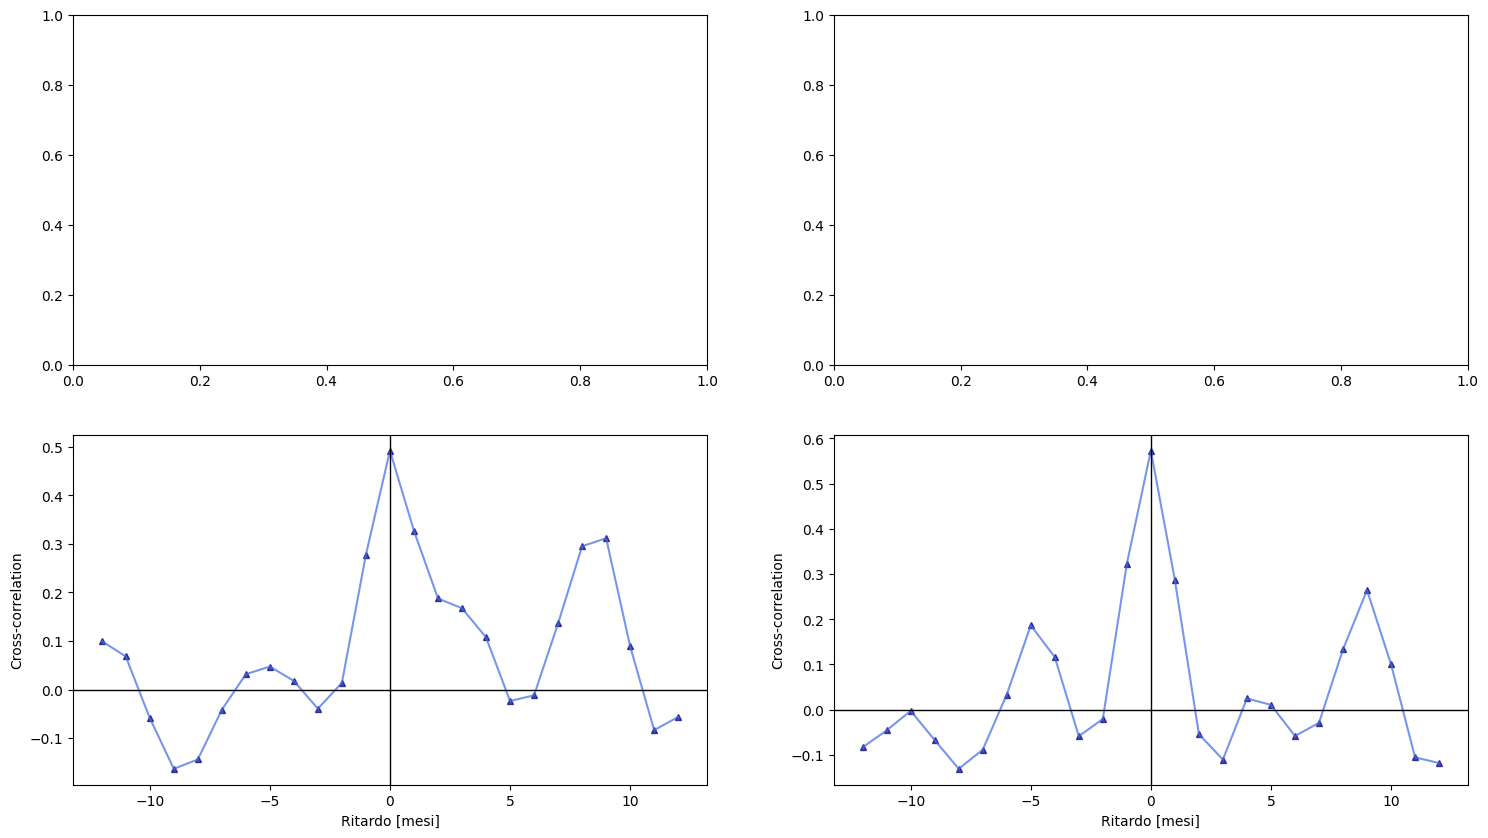

In [82]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds1 = int(11*12)
# Disegna i grafici
cross_correlation(wf_pch[ds1:],boa_pch[ds1:], max_lag=12, periodo='mesi',ax=axes[1, 0])
cross_correlation(wf_pch[ds1:],cg_pch[ds1:], max_lag=12, periodo='mesi',ax=axes[1, 1])

Correlazione massima:  0.7468259592993824  con ritardo di 0 mesi
Correlazione minima:  -0.25122978287535247  con ritardo di -6 mesi


(0, -6)

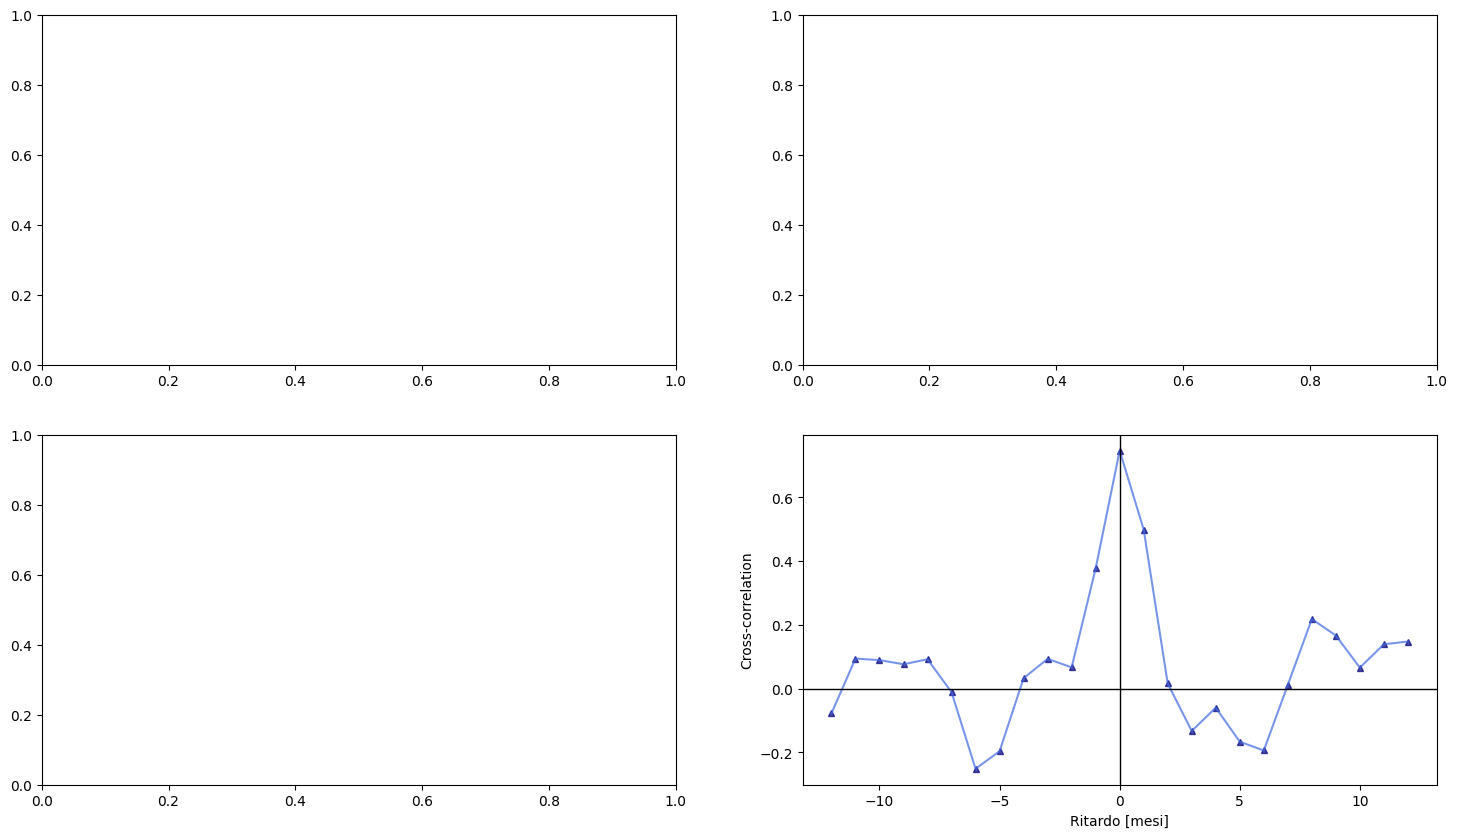

In [83]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(18,10),nrows=2, ncols=2)
ds1 = int(8*12)
# Disegna i grafici
cross_correlation(boa_pch[ds1:],cg_pch[ds1:], max_lag=12, periodo='mesi',ax=axes[1, 1])

Granger: scegliere ogni volta quale serie verificare

AIC     13
BIC      5
HQIC     5
FPE     13
dtype: int64


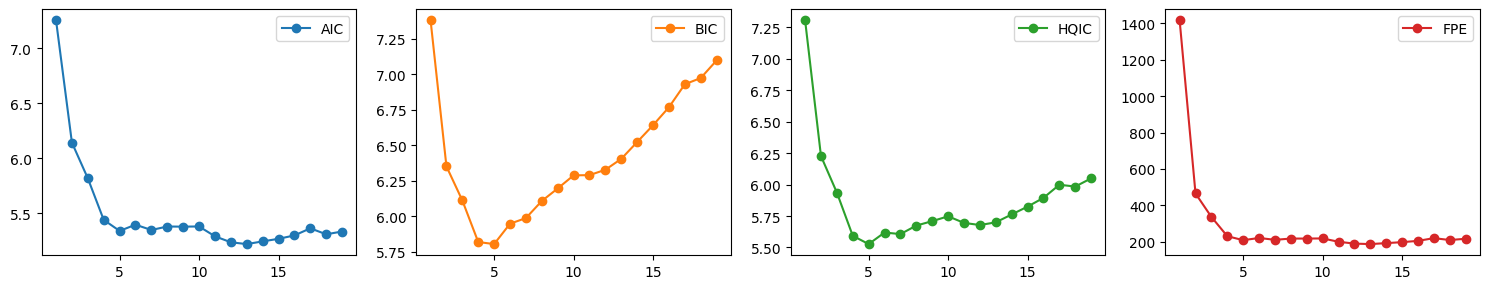

In [84]:
data_df = stock_pch.drop(['GS', 'BoA', 'CG'], axis=1)
train_df, test_df = splitter(data_df)
select_p(train_df)


In [85]:
p = 5
model = VAR(train_df)
var_model = model.fit(p)
granger_causation_matrix(train_df, train_df.columns, p)  

,JPM_x,WF_x
JPM_y,1.0000,0.0097
WF_y,0.0002,1.0000


Recall: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

----
# Crisi, Disoccupazione, Pil e Tasso di morosità dei mutui subprime
----

In [86]:
ur = pd.read_excel('UNRATE.xls', header = 11)
gdp = pd.read_excel('GDP.xls', header=12)
mp = pd.read_excel('MorositaMutui.xls', header=10)
t1 = np.arange(2000+0.25,2015+1/4,1/4)
er_pch = ur['EMRATE_PCH'][1:].values
gdp_pch = gdp['GDP_PCH'][1:].values
mp_pch = mp['DRSFRMACBS_PCH'][1:].values

poc = pd.DataFrame({'PIL':gdp_pch,'ER':er_pch, 'MT':mp_pch})
poc.to_excel('piloccupazionecase.xlsx', index=False)
gdp.set_index('observation_date', inplace=True)
ur.set_index('observation_date', inplace=True)
mp.set_index('observation_date', inplace=True)
gdp_M = gdp[:len(gdp)-1]


In [87]:
cg_pc = np.mean(np.array(cg_unf_pch).reshape(-1, 3), axis=1)
jpm_pc = np.mean(np.array(jpm_unf_pch).reshape(-1, 3), axis=1)
boa_pc = np.mean(np.array(boa_unf_pch).reshape(-1, 3), axis=1)
gs_pc = np.mean(np.array(gs_unf_pch).reshape(-1, 3), axis=1)
wf_pc = np.mean(np.array(wf_unf_pch).reshape(-1, 3), axis=1)

magia = pd.concat([gdp_M,pd.DataFrame(cg_pc,index=gdp_M.index,columns=["CG"]),pd.DataFrame(jpm_pc,index=gdp_M.index,columns=["JPM"]),pd.DataFrame(wf_pc,index=gdp_M.index,columns=["WFC"]),pd.DataFrame(boa_pc,index=gdp_M.index,columns=["BOA"]),pd.DataFrame(gs_pc,index=gdp_M.index,columns=["GS"])],axis=1)
magiavera = magia.drop(['GDP', 'GDP_CHG', 'GDP_PCH'], axis=1)

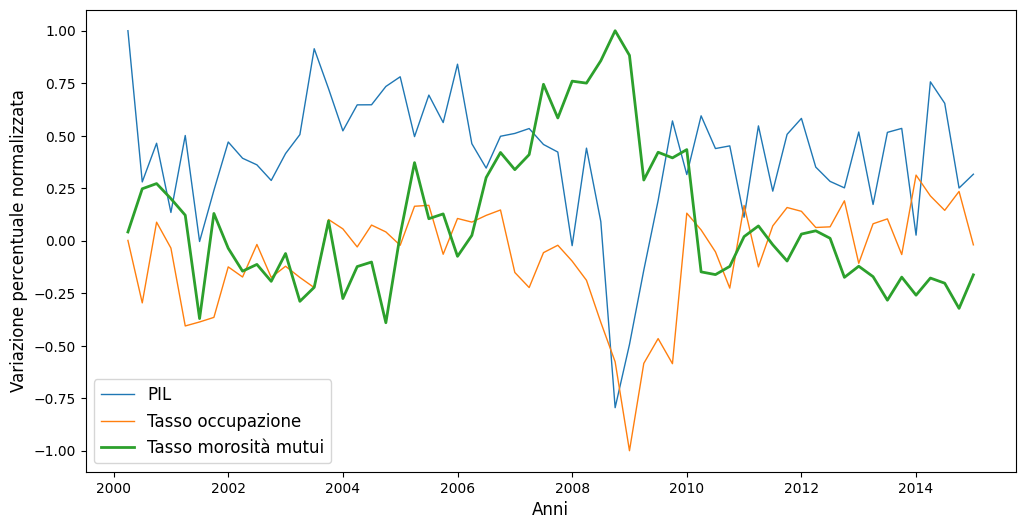

In [88]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(t1,normalize(gdp_pch),label='PIL', lw=1)
plt.plot(t1,normalize(er_pch),label='Tasso occupazione', lw=1)
plt.plot(t1,normalize(mp_pch),label='Tasso morosità mutui', lw=2)
plt.legend(loc='lower left', fontsize=12)
plt.xlabel('Anni', fontsize=12)
plt.ylabel('Variazione percentuale normalizzata', fontsize=12)
fig.savefig('var2.pdf')


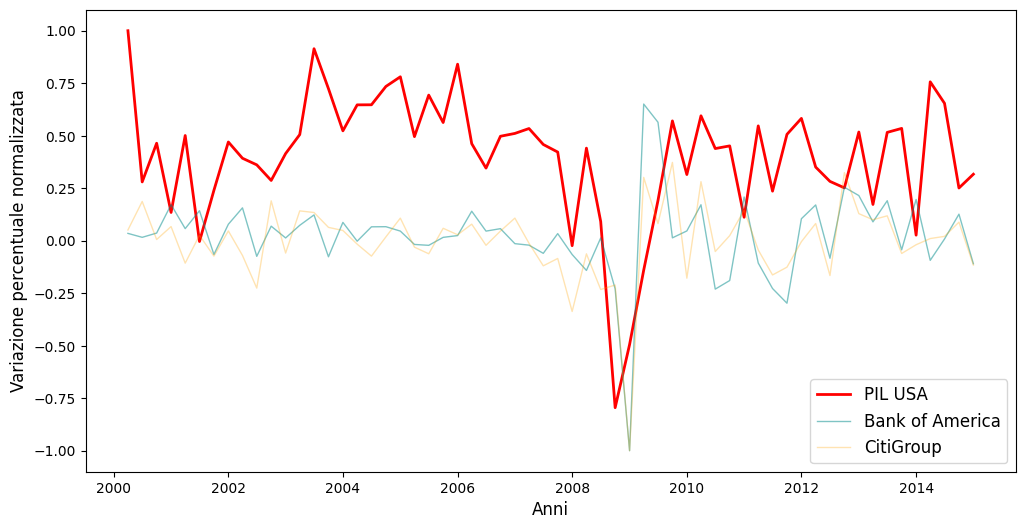

In [89]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gdp.index[1:],normalize(gdp_pch),label='PIL USA', lw=2, color='r')
plt.plot(gdp.index[1:],normalize(boa_pc),label='Bank of America',alpha=0.5, lw=1, color='darkcyan')
plt.plot(gdp.index[1:],normalize(cg_pc),label='CitiGroup',alpha=0.3, lw=1, color='orange')
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('Anni', fontsize=12)
plt.ylabel('Variazione percentuale normalizzata', fontsize=12)
plt.show()
fig.savefig('PilBanche.pdf')


Cross correlation prima dopo durante la crisi

Correlazione massima:  0.5117948717948718  con ritardo di 1 trimestri
Correlazione minima:  -0.2776057791537668  con ritardo di 9 trimestri
Correlazione massima:  0.6208791208791209  con ritardo di 2 trimestri
Correlazione minima:  -0.43356643356643365  con ritardo di -3 trimestri
Correlazione massima:  0.5252747252747253  con ritardo di -4 trimestri
Correlazione minima:  -0.6411764705882352  con ritardo di 2 trimestri


(-4, 2)

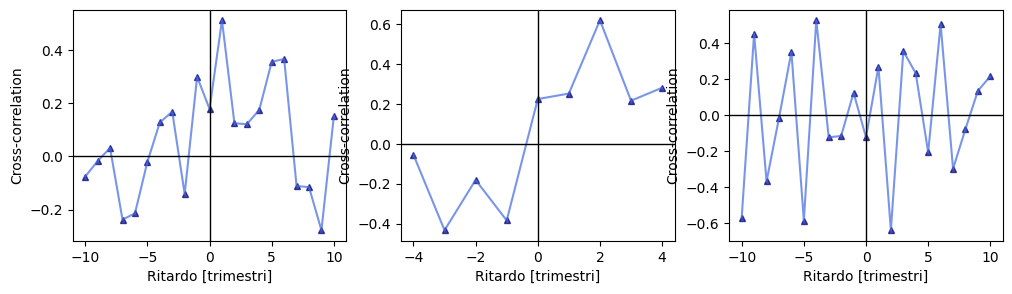

In [90]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(12,3),nrows=1, ncols=3)
cross_correlation(jpm_pc[0:27],gdp_pch[0:27],max_lag=10, periodo='trimestri',ax=axes[0])
cross_correlation(jpm_pc[27:42],gdp_pch[27:42],max_lag=4, periodo='trimestri',ax=axes[1])
cross_correlation(jpm_pc[42:],gdp_pch[42:],max_lag=10, periodo='trimestri',ax=axes[2])

Correlazione massima:  0.4504347826086956  con ritardo di -3 trimestri
Correlazione minima:  -0.2693498452012384  con ritardo di 9 trimestri
Correlazione massima:  0.5941176470588235  con ritardo di 2 trimestri
Correlazione minima:  -0.21470588235294116  con ritardo di -2 trimestri
Correlazione massima:  0.7412587412587414  con ritardo di 6 trimestri
Correlazione minima:  -0.6363636363636362  con ritardo di -8 trimestri


(6, -8)

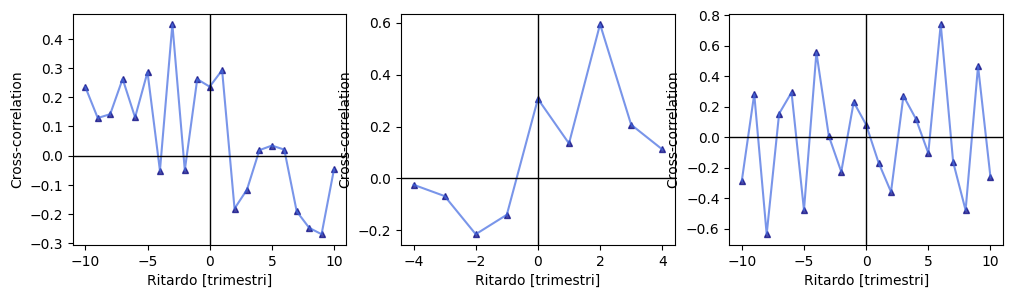

In [91]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(12,3),nrows=1, ncols=3)
cross_correlation(gs_pc[0:27],gdp_pch[0:27],max_lag=10, periodo='trimestri',ax=axes[0])
cross_correlation(gs_pc[24:42],gdp_pch[24:42],max_lag=4, periodo='trimestri',ax=axes[1])
cross_correlation(gs_pc[42:],gdp_pch[42:],max_lag=10, periodo='trimestri',ax=axes[2])

### Cross-correlation




Correlazione massima:  0.743859649122807  con ritardo di -1 trimestri
Correlazione minima:  -0.3928571428571428  con ritardo di -5 trimestri
Correlazione massima:  0.8333333333333333  con ritardo di 6 trimestri
Correlazione minima:  -0.8186813186813187  con ritardo di -2 trimestri


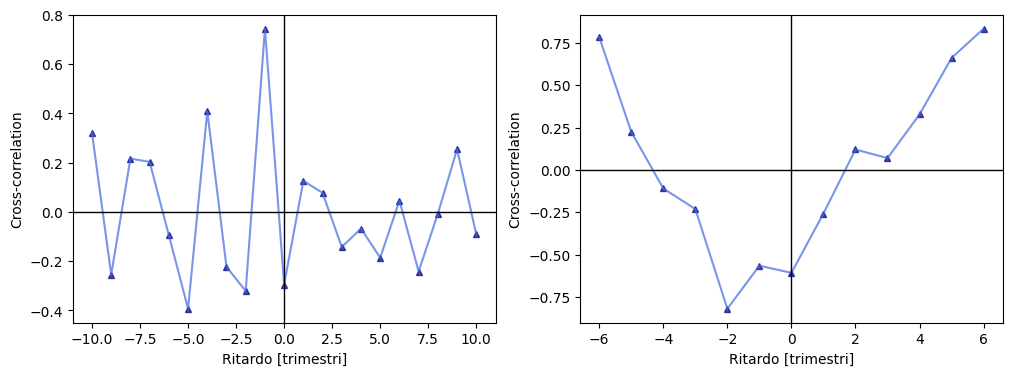

In [92]:
fig, axes = plt.subplots(figsize=(12,4),nrows=1, ncols=2)
cross_correlation(gdp_pch[40:],er_pch[40:],max_lag=10, periodo='trimestri',ax=axes[0])
cross_correlation(gdp_pch[27:42],mp_pch[27:42],max_lag=6, periodo='trimestri',ax=axes[1])
fig.savefig('cc2.pdf')

Correlazione massima:  0.6978865406006673  con ritardo di 2 trimestri
Correlazione minima:  -0.5008469791078487  con ritardo di -10 trimestri
Correlazione massima:  0.7406593406593407  con ritardo di 1 trimestri
Correlazione minima:  -0.8090909090909091  con ritardo di -4 trimestri
Correlazione massima:  0.743859649122807  con ritardo di -1 trimestri
Correlazione minima:  -0.3928571428571428  con ritardo di -5 trimestri


(-1, -5)

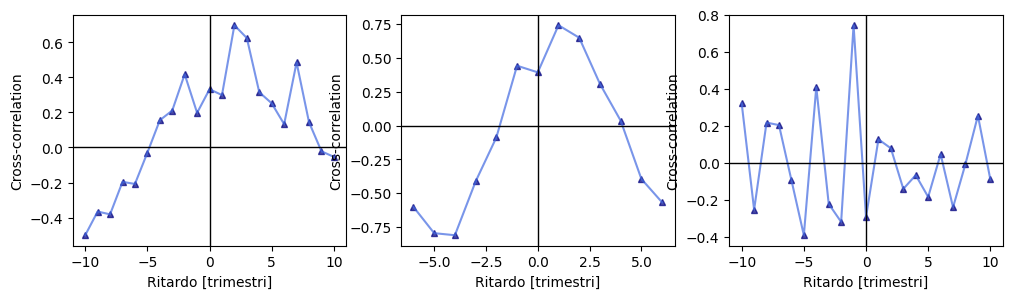

In [93]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(12,3),nrows=1, ncols=3)
cross_correlation(gdp_pch[0:32],er_pch[0:32],max_lag=10, periodo='trimestri',ax=axes[0])
cross_correlation(gdp_pch[27:42],er_pch[27:42],max_lag=6, periodo='trimestri',ax=axes[1])
cross_correlation(gdp_pch[40:],er_pch[40:],max_lag=10, periodo='trimestri',ax=axes[2])

Correlazione massima:  0.36764705882352944  con ritardo di -6 trimestri
Correlazione minima:  -0.7142857142857143  con ritardo di 9 trimestri
Correlazione massima:  0.7545454545454545  con ritardo di 4 trimestri
Correlazione minima:  -0.8391608391608393  con ritardo di -3 trimestri
Correlazione massima:  0.30000000000000004  con ritardo di -9 trimestri
Correlazione minima:  -0.6  con ritardo di 10 trimestri


(-9, 10)

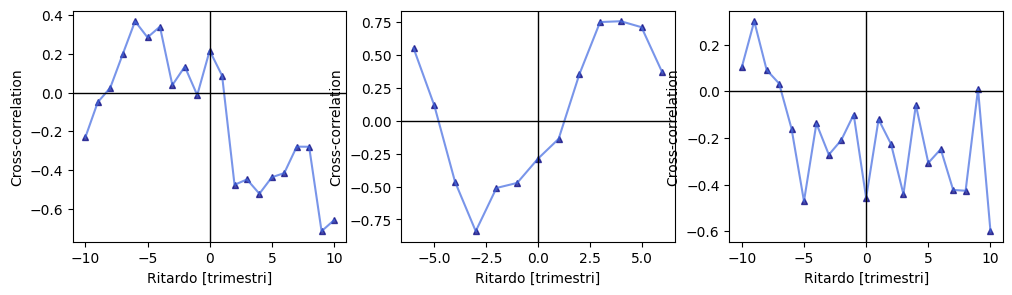

In [94]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(12,3),nrows=1, ncols=3)
cross_correlation(mp_pch[0:22],er_pch[0:22],max_lag=10, periodo='trimestri',ax=axes[0])
cross_correlation(er_pch[27:42],mp_pch[27:42],max_lag=6, periodo='trimestri',ax=axes[1])
cross_correlation(er_pch[40:],mp_pch[40:],max_lag=10, periodo='trimestri',ax=axes[2])

Correlazione massima:  0.6992307692307692  con ritardo di 7 trimestri
Correlazione minima:  -0.6208791208791209  con ritardo di -5 trimestri
Correlazione massima:  0.8333333333333333  con ritardo di 6 trimestri
Correlazione minima:  -0.8186813186813187  con ritardo di -2 trimestri
Correlazione massima:  0.3706293706293707  con ritardo di 8 trimestri
Correlazione minima:  -0.26842105263157895  con ritardo di -1 trimestri


(8, -1)

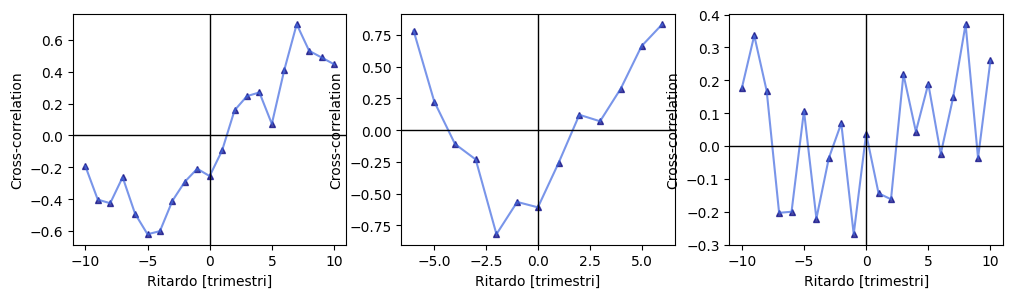

In [95]:
# Crea il subplot
fig, axes = plt.subplots(figsize=(12,3),nrows=1, ncols=3)
cross_correlation(gdp_pch[0:32],mp_pch[0:32],max_lag=10, periodo='trimestri',ax=axes[0])
cross_correlation(gdp_pch[27:42],mp_pch[27:42],max_lag=6, periodo='trimestri',ax=axes[1])
cross_correlation(gdp_pch[40:],mp_pch[40:],max_lag=10, periodo='trimestri',ax=axes[2])

### Granger: scegliere ogni volta i dati da verificare

AIC     8
BIC     1
HQIC    2
FPE     8
dtype: int64


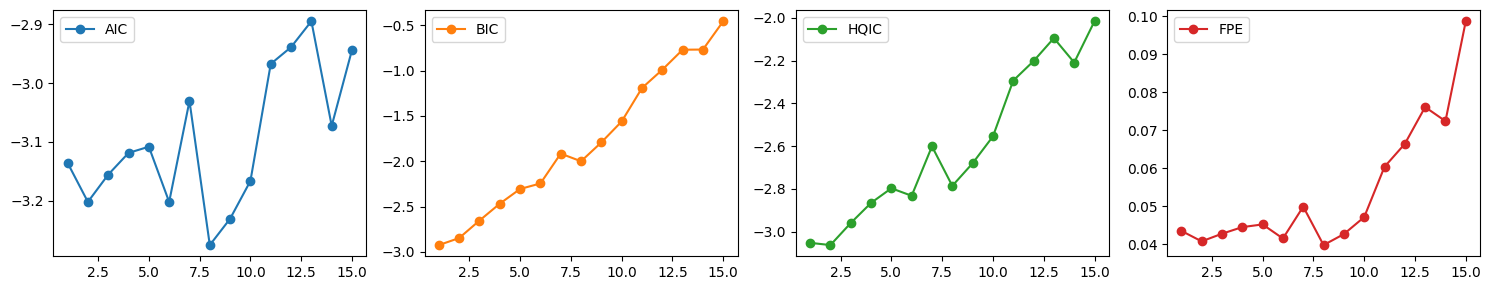

In [96]:
data_df = poc.drop(['MT'], axis=1)
select_p(data_df,maxlag=16)

In [97]:
p = 1
model = VAR(data_df)
var_model = model.fit(p)
granger_causation_matrix(data_df, data_df.columns, p)  

,PIL_x,ER_x
PIL_y,1.0000,0.0039
ER_y,0.0002,1.0000


----
### IMPULSO DELTA DI KRONECKER
----

R-squared GDP_PCH: 0.311590899800922
R-squared DRSFRMACBS_PCH: 0.1658045716308142
R-squared CG: 0.47896710074270554
R-squared BOA: 0.4048219870930845
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Apr, 2023
Time:                     12:16:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.96771
Nobs:                     59.0000    HQIC:                  -5.09651
Log likelihood:          -8.65478    FPE:                 0.00563473
AIC:                     -5.17898    Det(Omega_mle):      0.00510262
--------------------------------------------------------------------
Results for equation GDP_PCH
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.759946         0.170262            4.463           0.00

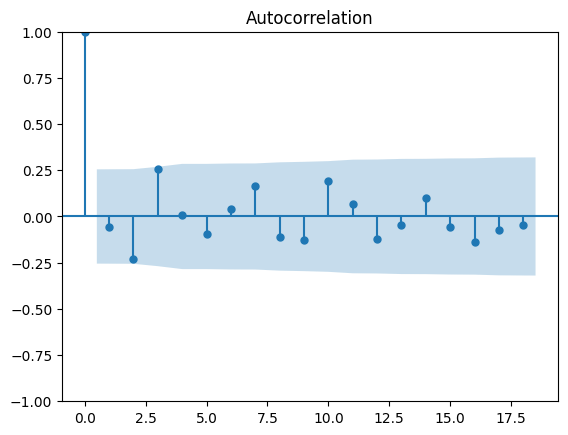

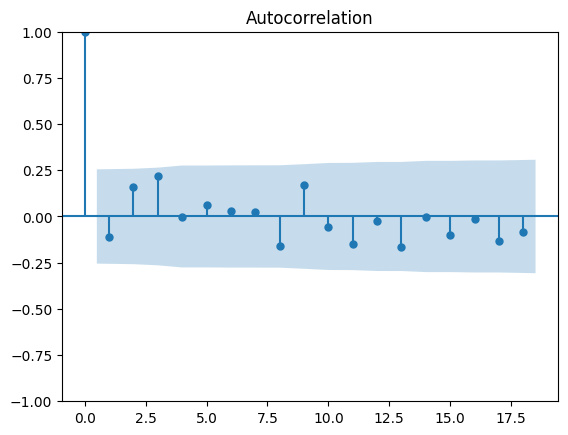

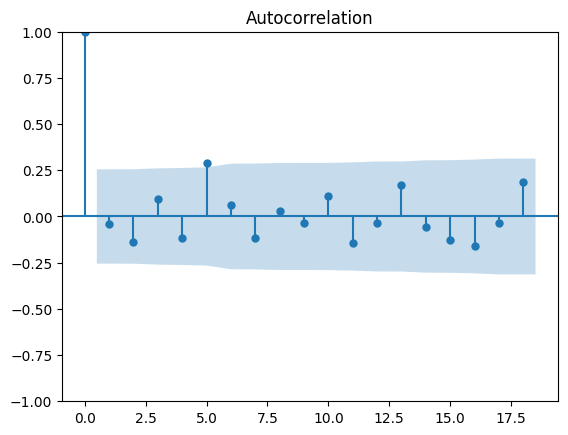

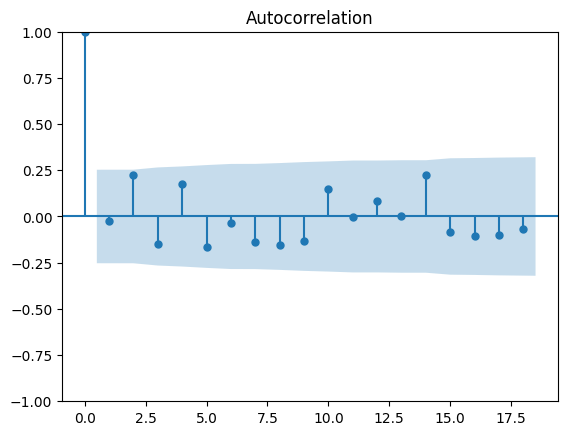

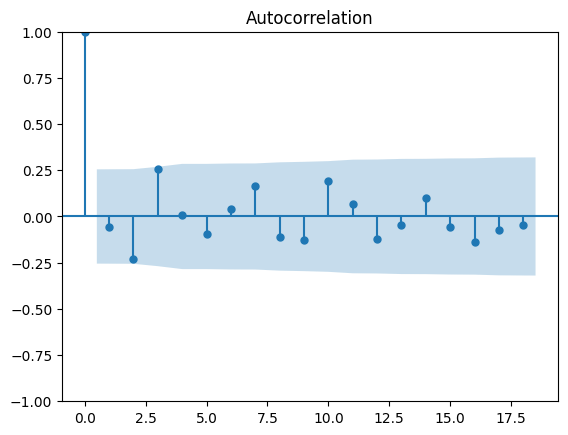

In [98]:
# Carica i dati del PIL e delle azioni delle banche
pil = gdp_M['GDP_PCH']
mutui = mp['DRSFRMACBS_PCH']
azioni = magiavera

# Crea una nuova serie temporale per l'impulso della crisi del 2008
impulso = pd.Series([0.125,1, 0.0625], index=[pd.to_datetime('2008-07-01'), pd.to_datetime('2008-10-01'), pd.to_datetime('2009-01-01')], name='Impulso')

# Aggiungi l'impulso alle serie temporali di PIL e azioni delle banche
pil = pd.concat([pil, impulso], axis=1, join='outer').fillna(0)
mutui = pd.concat([mutui, impulso], axis=1, join='outer').fillna(0)
azioni = pd.concat([azioni, impulso], axis=1, join='outer').fillna(0)
# Esegui l'analisi delle correlazioni
corr_pil = pil.corr()
corr_mutui = mutui.corr()
corr_azioni = azioni.corr()

# Esegui la regressione del PIL sull'impulso della crisi
x = pil['Impulso'].values.reshape(-1, 1)
y = pil['GDP_PCH'].values.reshape(-1, 1)
model = LinearRegression().fit(x, y)
r_squared = model.score(x, y)
print('R-squared GDP_PCH:', r_squared)

# Esegui la regressione dei mutui sull'impulso della crisi
x = mutui['Impulso'].values.reshape(-1, 1)
y = mutui['DRSFRMACBS_PCH'].values.reshape(-1, 1)
model = LinearRegression().fit(x, y)
r_squared = model.score(x, y)
print('R-squared DRSFRMACBS_PCH:', r_squared)

# Esegui la regressione delle azioni delle banche sull'impulso della crisi
x = azioni['Impulso'].values.reshape(-1, 1)
y = azioni['CG'].values.reshape(-1, 1)
model = LinearRegression().fit(x, y)
r_squared = model.score(x, y)
print('R-squared CG:', r_squared)

# Esegui la regressione delle azioni delle banche sull'impulso della crisi
x = azioni['Impulso'].values.reshape(-1, 1)
y = azioni['BOA'].values.reshape(-1, 1)
model = LinearRegression().fit(x, y)
r_squared = model.score(x, y)
print('R-squared BOA:', r_squared)

# Esegui l'analisi causale utilizzando modelli VAR
model = sm.tsa.VAR(pil[['GDP_PCH', 'Impulso']])
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['GDP_PCH']
plot_acf(residuals)

model = sm.tsa.VAR(mutui[['DRSFRMACBS_PCH', 'Impulso']])
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['DRSFRMACBS_PCH']
plot_acf(residuals)


model = sm.tsa.VAR(azioni[['CG', 'Impulso']])
results = model.fit(maxlags=4, ic='bic')
print(results.summary())
residuals = results.resid['CG']
plot_acf(residuals)

model = sm.tsa.VAR(azioni[['BOA', 'Impulso']])
results = model.fit(maxlags=4, ic='bic')
print(results.summary())
residuals = results.resid['BOA']
plot_acf(residuals)


### Plot impulso


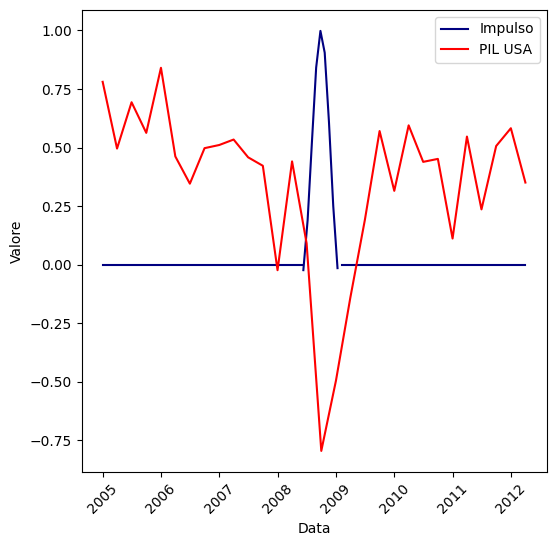

In [99]:
from scipy.interpolate import splrep, splev

# Definizione dell'oggetto impulso
impulso = azioni['Impulso'][20:len(azioni)-10]
impulso1 = pd.Series([0.125,1, 0.0625], index=[pd.to_datetime('2008-07-01'), pd.to_datetime('2008-10-01'), pd.to_datetime('2009-01-01')], name='Impulso')

# Interpolazione dei dati con una funzione di grado 5
x = impulso.index.astype(np.int64) // 10**9
y = impulso.values
tck = splrep(x, y, k=5)
x_new = np.linspace(x[0], x[-1], 100)
y_new = splev(x_new, tck)

# Creazione del grafico dell'oggetto impulso e della funzione interpolata
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pd.to_datetime(x_new*10**9)[47:56], y_new[47:56], color = 'navy', label='Impulso')
ax.plot(pd.to_datetime(x_new*10**9)[0:48], np.zeros(48), color = 'navy')
ax.plot(pd.to_datetime(x_new*10**9)[56:], np.zeros(len(x_new)-56), color = 'navy')
#ax.scatter([pd.to_datetime('2008-06-12'), pd.to_datetime('2008-10-01'), pd.to_datetime('2009-01-10')],[0.0003,0.98,0.0003], color='navy', marker='s',s=2)
ax.plot(gdp.index[20:50],normalize(gdp_pch)[19:49],label='PIL USA', lw=1.5, color='r')
# Personalizzazione del grafico
ax.set_xlabel('Data')
ax.set_ylabel('Valore')
ax.legend()
plt.xticks(rotation=45) # rotazione delle etichette sull'asse x
plt.show()
fig.savefig('imp1.pdf')


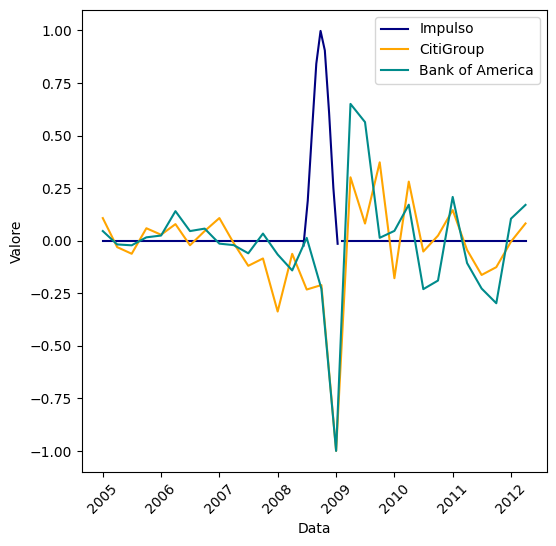

In [100]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pd.to_datetime(x_new*10**9)[47:56], y_new[47:56], color = 'navy', label='Impulso')
ax.plot(pd.to_datetime(x_new*10**9)[0:48], np.zeros(48), color = 'navy')
ax.plot(pd.to_datetime(x_new*10**9)[56:], np.zeros(len(x_new)-56), color = 'navy')
#ax.scatter([pd.to_datetime('2008-06-12'), pd.to_datetime('2008-10-01'), pd.to_datetime('2009-01-10')],[0.0003,0.98,0.0003], color='navy', marker='s',s=2)
ax.plot(gdp.index[20:50],normalize(cg_pc)[19:49],label='CitiGroup', lw=1.5, color='orange')
ax.plot(gdp.index[20:50],normalize(boa_pc)[19:49],label='Bank of America', lw=1.5, color='darkcyan')
# Personalizzazione del grafico
ax.set_xlabel('Data')
ax.set_ylabel('Valore')
ax.legend()
plt.xticks(rotation=45) # rotazione delle etichette sull'asse x
plt.show()
fig.savefig('imp2.pdf')